# Финальная работа, специализация: `Machine Learning Engineer`

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import missingno as msno
import matplotlib.pyplot as plt

import gc
import time
from datetime import datetime
import os
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


## Загрузка данных

In [3]:
# целевые действия
target_actions = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

### ga_sessions -> df_sessions

Одна строка = один визит на сайт.

In [4]:
path_sessions = '../data/ga_sessions.pkl'
df_sessions = pd.read_pickle(path_sessions)

In [5]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [6]:
df_sessions.shape

(1860042, 18)

- session_id — ID визита;
- client_id — ID посетителя;
- visit_date — дата визита;
- visit_time — время визита;
- visit_number — порядковый номер визита клиента;
- utm_source — канал привлечения;
- utm_medium — тип привлечения;
- utm_campaign — рекламная кампания;
- utm_keyword — ключевое слово;
- device_category — тип устройства;
- device_os — ОС устройства;
- device_brand — марка устройства;
- device_model — модель устройства;
- device_screen_resolution — разрешение экрана;
- device_browser — браузер;
- geo_country — страна;
- geo_city — город.

### ga_hits -> df_hits

Одна строка = одно событие в рамках одного визита на сайт.

In [7]:
path_hits = '../data/ga_hits-002.parquet'
df_hits = pd.read_parquet(path_hits)

In [8]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,6486174593177269061.1635764668.1635764668,2021-11-01,78361.0,15,event,None,sberauto.com/cars/all/skoda/octavia/4791c8b2?u...,card_web,view_card,<NA>,NaN
1,6486174593177269061.1635764668.1635764668,2021-11-01,79928.0,19,event,None,sberauto.com/cars/all/skoda/octavia/4791c8b2?u...,card_web,view_card,<NA>,NaN
2,6486174593177269061.1635764668.1635764668,2021-11-01,197346.0,45,event,None,sberauto.com/cars/all/bmw/x7/6386081c?utm_sour...,card_web,view_card,<NA>,NaN
3,204580520987704299.1635759975.1635759975,2021-11-01,1061002.0,40,event,None,sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...,card_web,view_card,<NA>,NaN
4,8261193480355977682.1635751786.1635751786,2021-11-01,57906.0,31,event,None,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,card_web,view_card,<NA>,NaN


In [9]:
df_hits.shape

(5726470, 11)

- session_id — ID визита;
- hit_date — дата события;
- hit_time — время события;
- hit_number — порядковый номер события в рамках сессии;
- hit_type — тип события;
- hit_referer — источник события;
- hit_page_path — страница события;
- event_category — тип действия;
- event_action — действие;
- event_label — тег действия;
- event_value — значение результата действия.

## Data Preparation

### df_sessions

#### Просмотр данных

Изучим данные в датасете на предмет дубликатов, типа данных и пропущенных значений.

In [10]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [11]:
df_sessions.describe()

,visit_number
count,1.860042e+06
mean,2.712804e+00
std,1.182907e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.640000e+02


In [12]:
df_sessions.select_dtypes('object').describe()

,session_id,client_id,visit_date,visit_time,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1860042,1860042,1860042,1859945,1860042,1640439,1524427,777981,1860042,789904,1741364,16338,1860042,1860042,1860042,1860042
unique,1860042,1391719,226,85318,293,56,412,286,1219,3,13,206,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,462,39453,61067,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329


#### Duplicates

In [13]:
df_sessions[df_sessions.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city


Дубликаты в данных отсутствуют

#### Missing Data

In [14]:
((df_sessions.isna().sum() / len(df_sessions)) * 100).sort_values(ascending=False)

device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
utm_adcontent               18.043410
utm_campaign                11.806346
device_brand                 6.380394
utm_source                   0.005215
session_id                   0.000000
client_id                    0.000000
visit_number                 0.000000
utm_medium                   0.000000
visit_date                   0.000000
visit_time                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64

<Axes: >

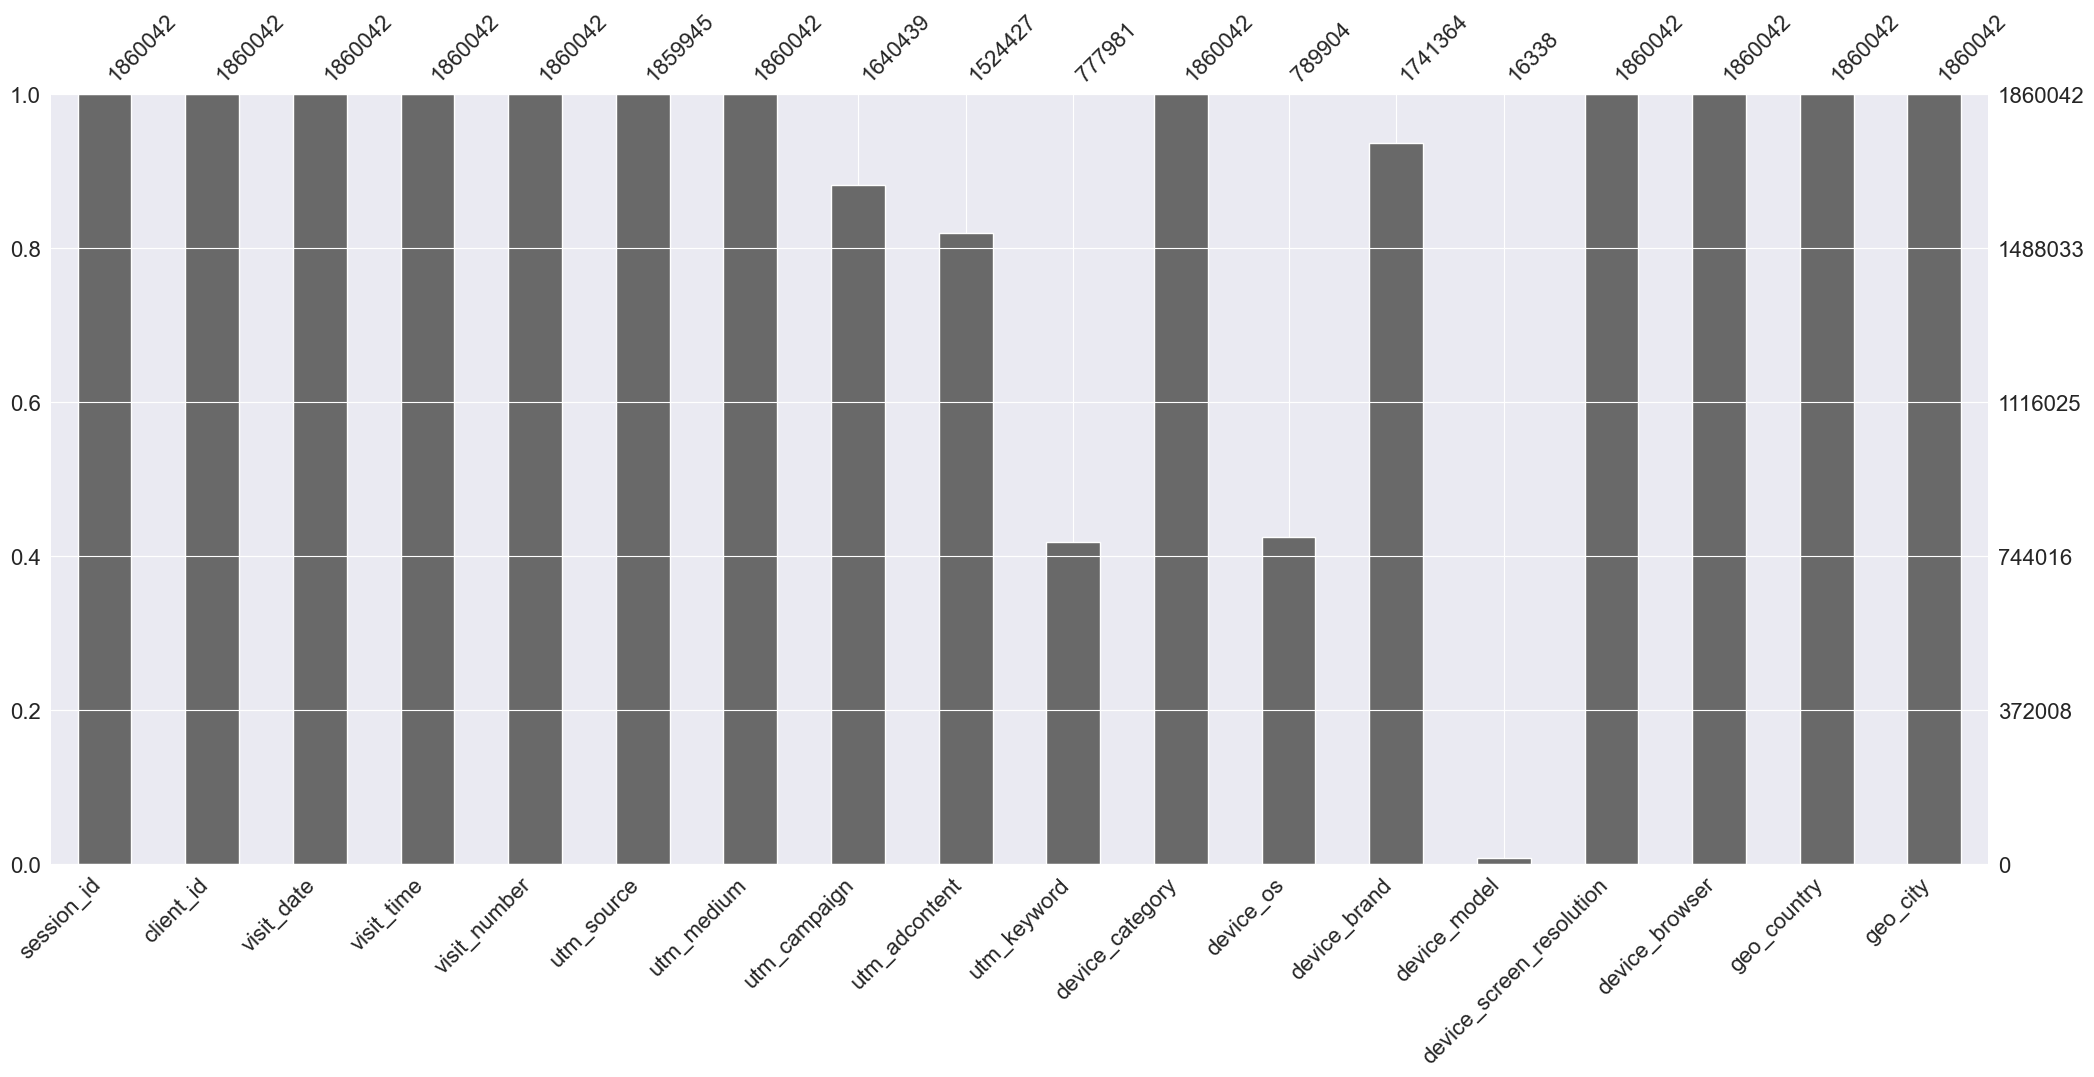

In [15]:
msno.bar(df_sessions)

##### Удаление ненужных колонок

Колонки `device_model` и `utm_keyword` имеют большое количество пропущенных значений, которые невозможно восстановить. Они подлежат удалению.

In [16]:
# Создаем копию датафрейма для возможности отката
df_sessions_clean = df_sessions.copy()

In [17]:
df_sessions_clean = df_sessions_clean.drop(columns=['device_model', 'utm_keyword'], axis=1)

<Axes: >

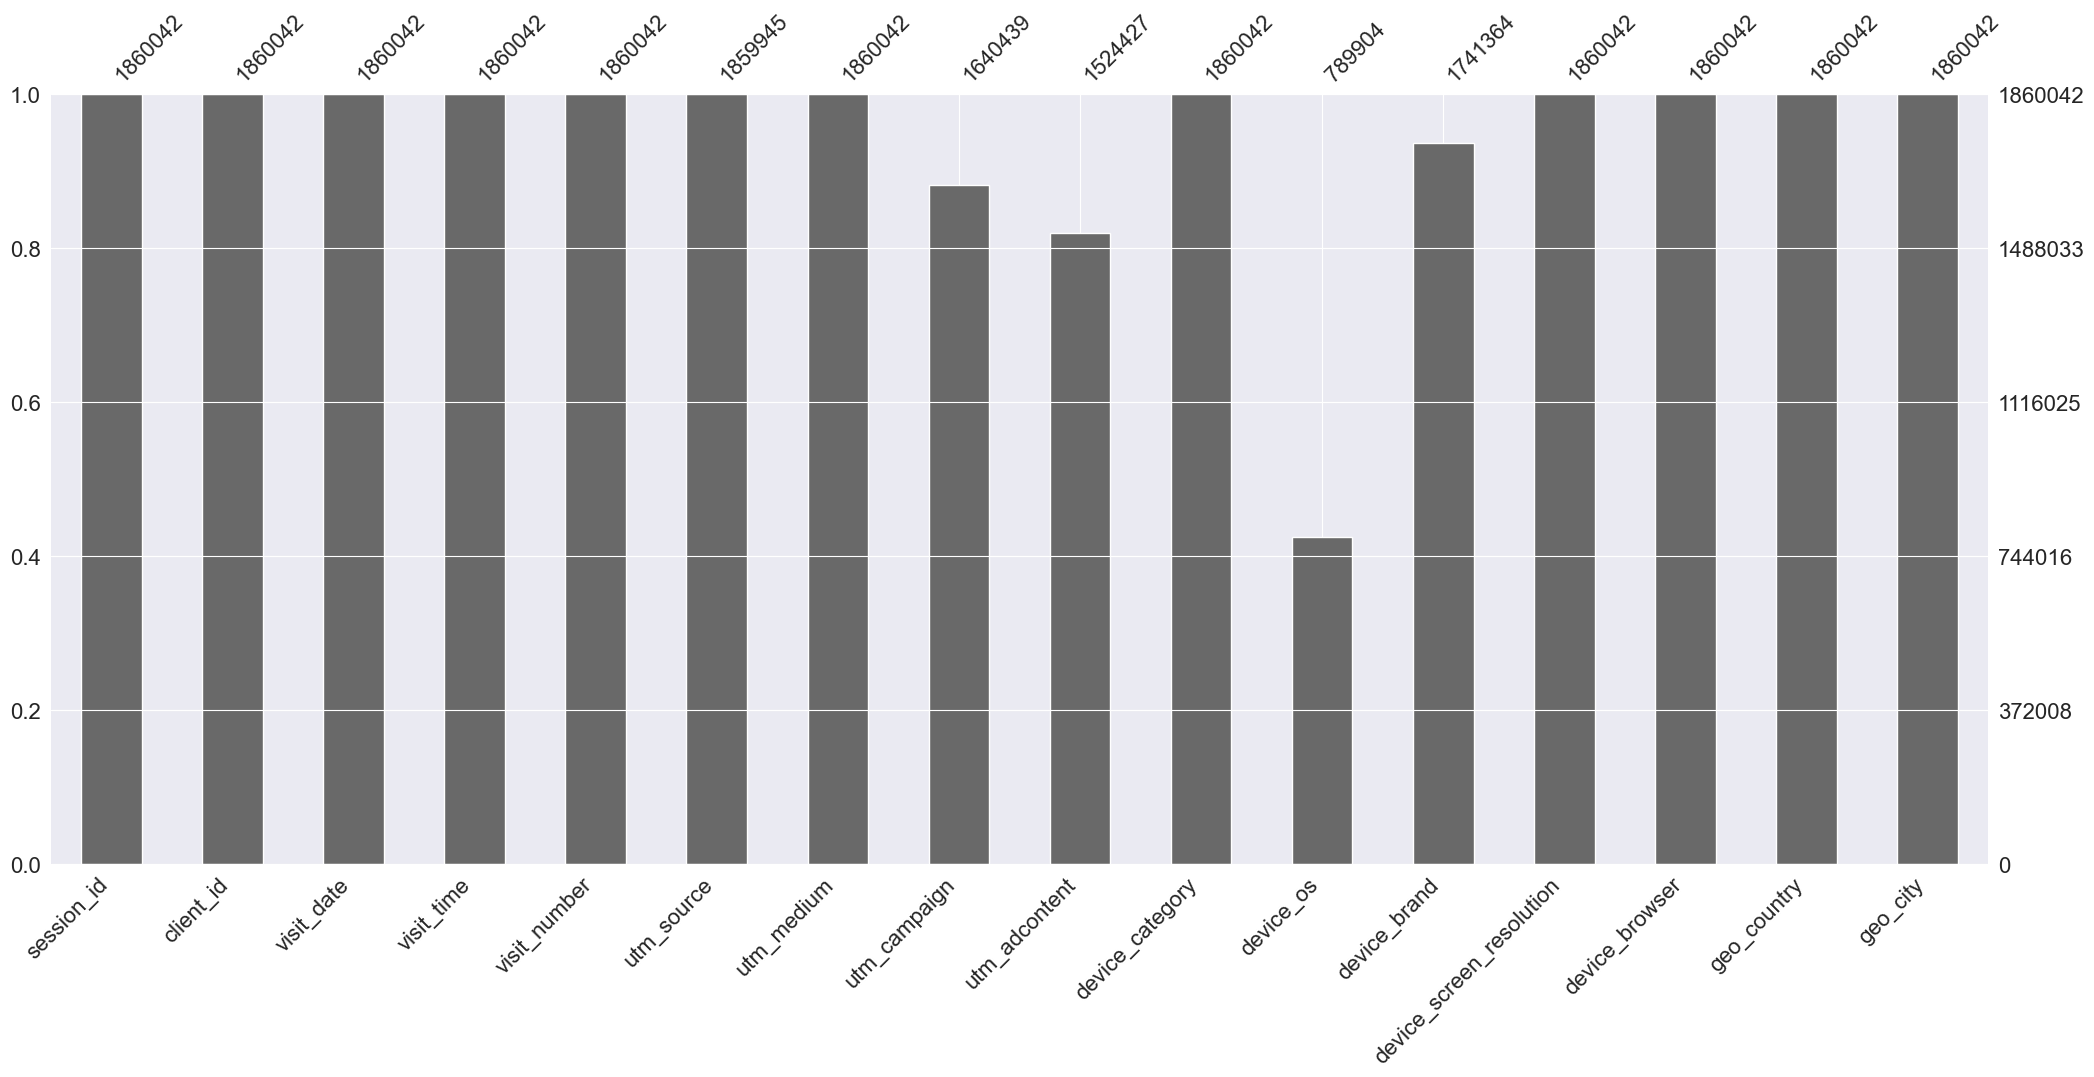

In [18]:
msno.bar(df_sessions_clean)

<Axes: >

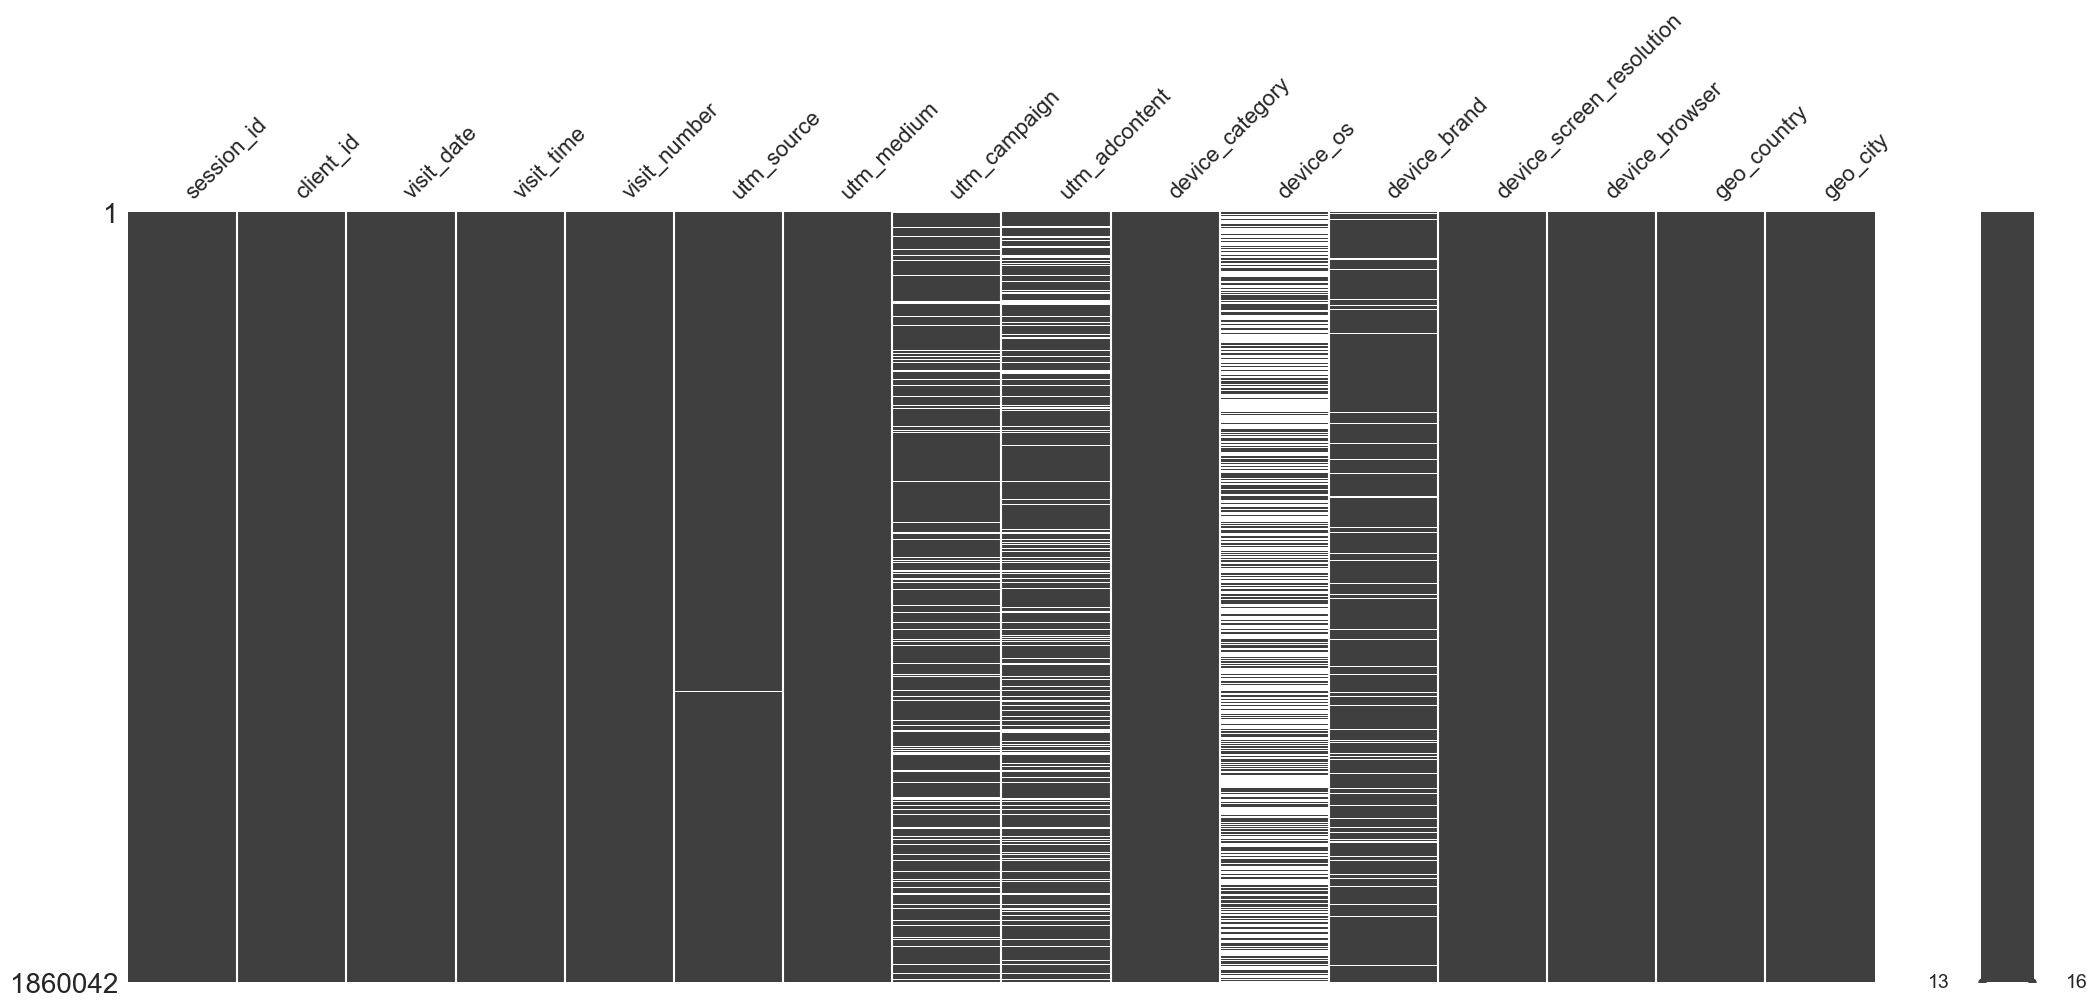

In [19]:
msno.matrix(df_sessions_clean)

Оставшиеся пропущенные значения можно заполнить.

In [20]:
(df_sessions_clean.isna().sum()).sort_values(ascending=False)

device_os                   1070138
utm_adcontent                335615
utm_campaign                 219603
device_brand                 118678
utm_source                       97
visit_time                        0
session_id                        0
client_id                         0
utm_medium                        0
visit_number                      0
visit_date                        0
device_category                   0
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

##### utm_source

Количество пропусков = 97. Это слишком маленькое количество от общих размеров датасета.

In [21]:
df_sessions_clean.utm_source.isna().sum() / len(df_sessions_clean) * 100

np.float64(0.0052149360068213515)

Такой низкий процент не повлияет на работоспособность модели. Эти строки будет целесообразнее удалить.

In [22]:
df_sessions_clean2 = df_sessions_clean.dropna(subset=['utm_source'])
df_sessions_clean2.utm_source.isna().sum()

np.int64(0)

##### device_brand & device_os

In [23]:
set(df_sessions_clean2.device_brand.values)

{'',
 '(not set)',
 'A1',
 'AGM',
 'AT&T',
 'Acer',
 'Advan',
 'Alcatel',
 'Alldocube',
 'Amazon',
 'Ananda',
 'Apple',
 'Archos',
 'Ark',
 'Artel',
 'Asus',
 'BLU',
 'BLUBOO',
 'BQ',
 'Beelink',
 'Billion',
 'Black Fox',
 'BlackBerry',
 'Blackview',
 'CAT',
 'Caterpillar',
 'Celkon',
 'Centric',
 'China Mobile',
 'China Phone',
 'China TVBox',
 'Chuwi',
 'Condor',
 'Coolpad',
 'Corn',
 'Cube',
 'Cubot',
 'DEXP',
 'DOOGEE',
 'Dark',
 'Dell',
 'Digiland',
 'Digma',
 'Dragon Touch',
 'Dynamic',
 'E&L',
 'Egreat',
 'Elephone',
 'Ellipsis',
 'Essential',
 'Evercoss',
 'Evertek',
 'Explay',
 'FREETEL',
 'Fairphone',
 'Fero',
 'Flexymove',
 'Fly',
 'Flylion',
 'Fujitsu',
 'General Mobile',
 'Geotel',
 'Gigaset',
 'Gionee',
 'Gome',
 'Google',
 'Gretel',
 'Guophone',
 'H96',
 'HOMTOM',
 'HTC',
 'Hafury',
 'Haier',
 'Highscreen',
 'Hisense',
 'Honeywell',
 'Honor',
 'How',
 'Huawei',
 'INUI',
 'InFocus',
 'Infinix',
 'InnJoo',
 'Inoi',
 'Irbis',
 'Iris',
 'Itoos',
 'Jiake',
 'Jiayu',
 'Karbonn

In [24]:
set(df_sessions_clean2.device_os.values)

{'(not set)',
 'Android',
 'BlackBerry',
 'Chrome OS',
 'Firefox OS',
 'Linux',
 'Macintosh',
 'Nokia',
 None,
 'Samsung',
 'Tizen',
 'Windows',
 'Windows Phone',
 'iOS'}

Колонка `device_os` также имеет пропущенные значения, однако она может быть полезна. Информацию можно восстановить, исходя из информации колонки `device_brand`.

In [25]:
def smart_fill_device_os(df):
    """
    Умное заполнение device_os на основе существующих паттернов в данных
    """
    brand_os_patterns = df[df['device_os'].notna() & (df['device_os'] != 'None')].groupby('device_brand')['device_os'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown').to_dict()

    df_filled = df.copy()

    mask_missing = df_filled['device_os'].isna() | (df_filled['device_os'] == 'None')
    df_filled.loc[mask_missing, 'device_os'] = df_filled.loc[mask_missing, 'device_brand'].map(brand_os_patterns)

    common_android_brands = ['Samsung', 'Huawei', 'Xiaomi', 'OPPO', 'Vivo', 'Realme', 'OnePlus',
                           'Motorola', 'LG', 'Sony', 'HTC', 'Asus', 'ZTE', 'Alcatel', 'Nokia']

    mask_still_missing = df_filled['device_os'].isna()
    df_filled.loc[mask_still_missing & df_filled['device_brand'].isin(common_android_brands), 'device_os'] = 'Android'

    # Apple - всегда iOS
    df_filled.loc[mask_still_missing & (df_filled['device_brand'] == 'Apple'), 'device_os'] = 'iOS'

    return df_filled

In [26]:
# Применяем умное заполнение
df_sessions_clean2 = smart_fill_device_os(df_sessions_clean2)

In [27]:
print(df_sessions_clean2.device_brand.isna().sum(), df_sessions_clean2.device_os.isna().sum())

118626 248578


In [28]:
df_sessions_clean2.device_brand.value_counts(dropna=False, sort=True)

device_brand
Apple      551078
Samsung    332187
Xiaomi     288358
           248500
Huawei     185836
            ...  
Maze            1
Tagital         1
FREETEL         1
Maxvi           1
Opera           1
Name: count, Length: 207, dtype: int64

In [29]:
df_sessions_clean2.device_os.value_counts(dropna=False, sort=True)

device_os
Android          941581
iOS              551084
NaN              248578
Windows           88298
Macintosh         24781
Linux              5120
(not set)           372
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

В колонках `device_brand` и `device_os` есть пустые значения, которые ложно заполнены. Это значения '' и '(not set)'. Также будем считать их пропущенными.

In [30]:
df_sessions_clean2['device_brand'] = df_sessions_clean2['device_brand'].replace(['', '(not set)'], None)

df_sessions_clean2['device_os'] = df_sessions_clean2['device_os'].replace([pd.NA, '(not set)'], None)

In [31]:
df_sessions_clean2

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk


<Axes: >

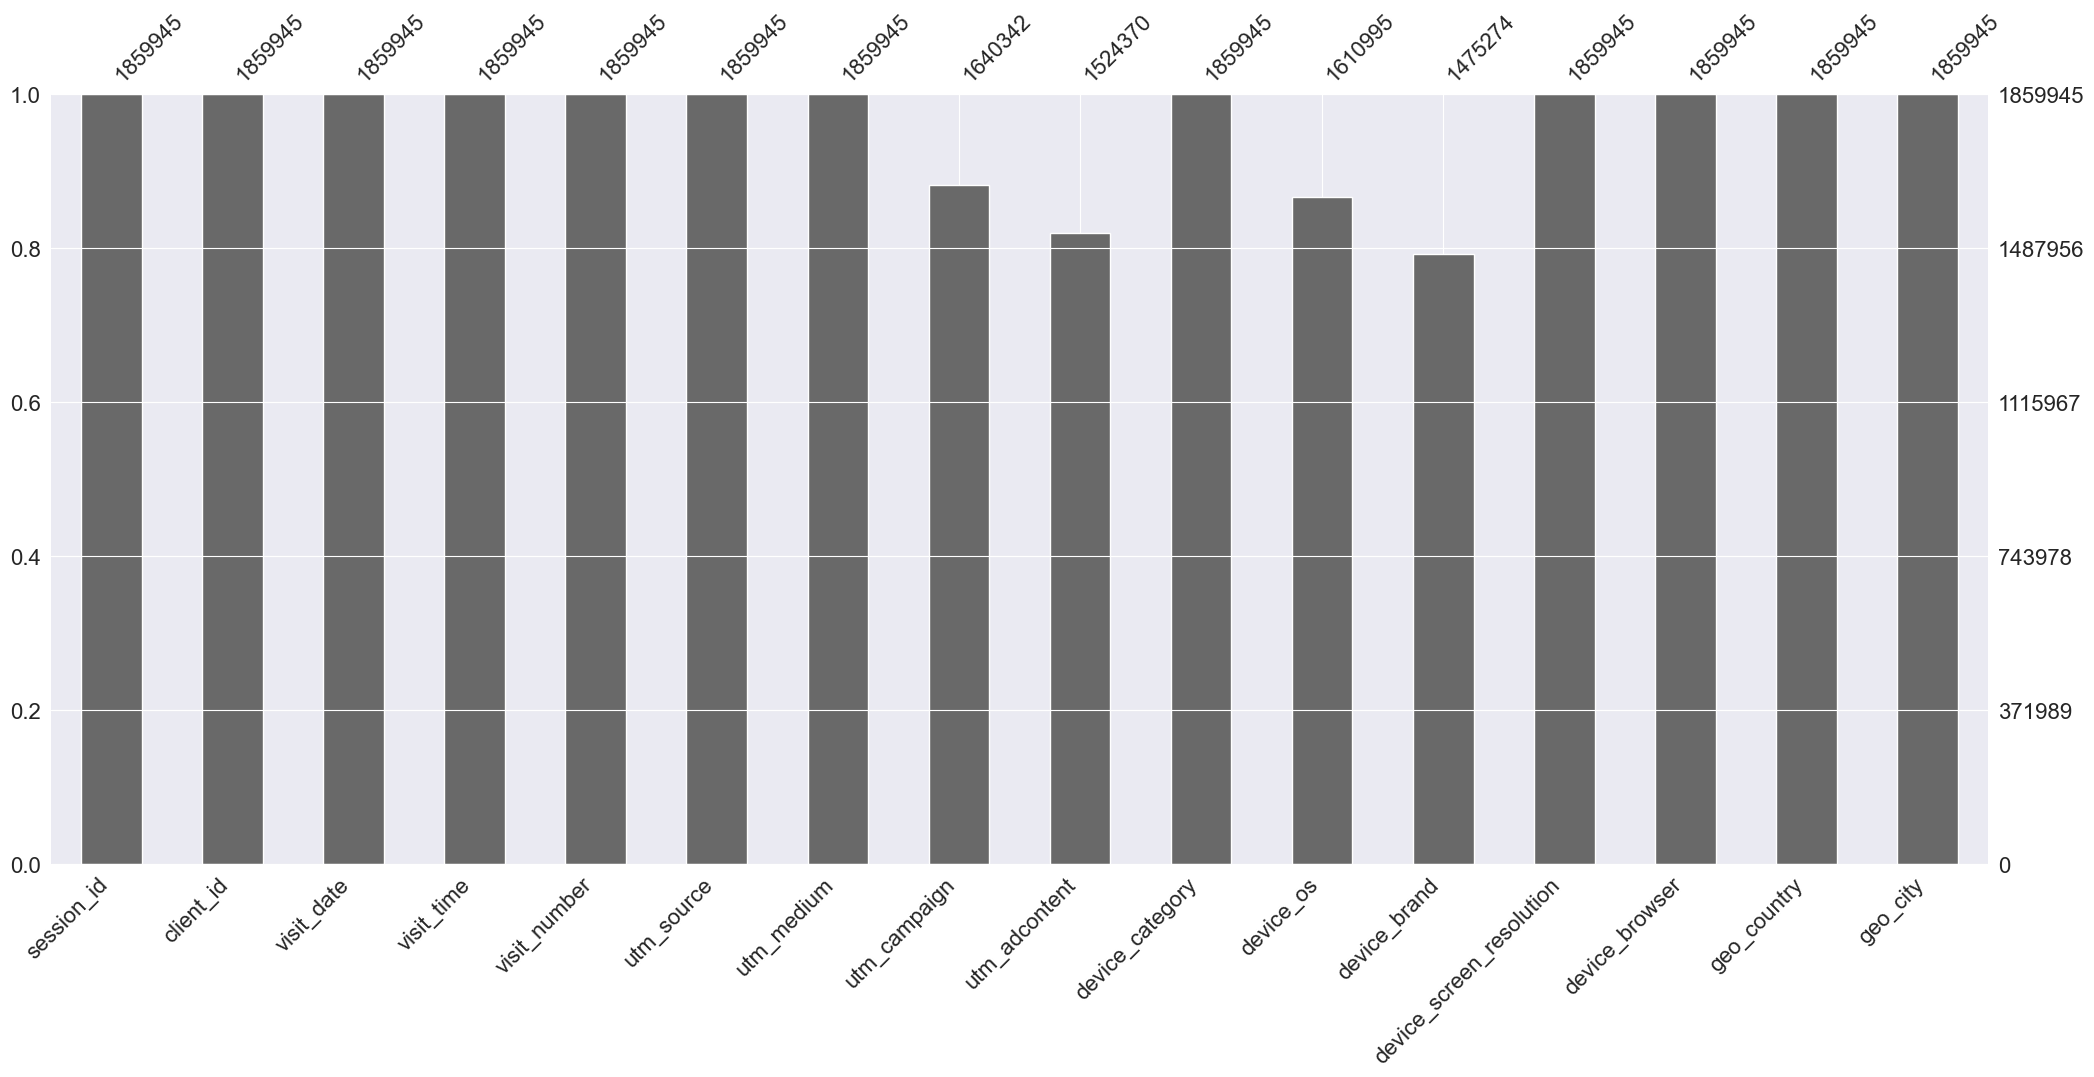

In [32]:
msno.bar(df_sessions_clean2)

In [33]:
df_sessions_clean2['device_category'].value_counts()

device_category
mobile     1474826
desktop     366811
tablet       18308
Name: count, dtype: int64

In [34]:
df_sessions_clean2[df_sessions_clean2['device_browser'] == 'Safari']['device_os'].value_counts(dropna=False)

device_os
iOS              437587
None              27445
Macintosh         13506
Android               6
Linux                 5
Windows Phone         2
Nokia                 1
Name: count, dtype: int64

После анализа замечено, что можно заполнить пропущенные значения устройств с помощью информации других столбцов. В этом также поможет факт, что браузер Safari принадлежит Apple, а если с этого браузера был выполнен вход с компьютера, то с наибольшей вероятностью `device_os` будет 'Macintosh', а `device_brand` будет 'Apple'.

In [35]:
def fill_apple_devices(df, category, os_fill_value='iOS'):
    """
    Заполняет пропуски для Apple устройств
    """
    mask = (df['device_browser'] == 'Safari') & (df['device_category'] == category)

    if mask.any():
        # device_os
        df.loc[mask, 'device_os'] = df.loc[mask, 'device_os'].fillna(os_fill_value)

        # device_brand
        df.loc[mask, 'device_brand'] = (
            df.loc[mask, 'device_brand']
            .replace(['', '(not set)'], 'Apple')
            .fillna('Apple')
        )

    return df

In [36]:
# Применяем для всех категорий
df_sessions_clean2 = fill_apple_devices(df_sessions_clean2, 'desktop', 'Macintosh')
df_sessions_clean2 = fill_apple_devices(df_sessions_clean2, 'mobile', 'iOS')
df_sessions_clean2 = fill_apple_devices(df_sessions_clean2, 'tablet', 'iOS')

In [37]:
df_sessions_clean2['device_brand'].value_counts(dropna=False, sort=True)

device_brand
Apple      592043
None       343706
Samsung    332187
Xiaomi     288358
Huawei     185836
            ...  
Maze            1
Tagital         1
FREETEL         1
Maxvi           1
Opera           1
Name: count, Length: 205, dtype: int64

In [38]:
df_sessions_clean2['device_os'].value_counts(dropna=False, sort=True)

device_os
Android          941581
iOS              551207
None             221505
Windows           88298
Macintosh         52103
Linux              5120
Chrome OS            83
BlackBerry           27
Tizen                 7
Samsung               4
Windows Phone         4
Firefox OS            3
Nokia                 3
Name: count, dtype: int64

Проверим остались ли незаполненными однозначные значения ОС при заполненном бренде устройства.

In [39]:
df_sessions_clean2[(df_sessions_clean2['device_brand'].notna()) & (df_sessions_clean2['device_os'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
2919,9068635812895644832.1627905184.1627905184,2111456313.1627905184,2021-08-02,14:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,None,China Phone,360x760,Chrome,Russia,Moscow
18396,9136800345495711099.1626353082.1626353643,2127327105.1626353019,2021-07-15,15:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,China Phone,360x640,Chrome,Russia,Saint Petersburg
88494,1149275220731870907.1625407163.1625407163,267586489.1625407163,2021-07-04,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,dUuXlWzvmhDSyclWRhNP,tablet,None,Flylion,1280x720,YaBrowser,Russia,Moscow
107433,1234231125553231556.1632941767.1632941767,287366827.1632941764,2021-09-29,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,tablet,None,Itoos,601x962,Chrome,Russia,Moscow
130287,1337338657370346433.1626674115.1626674115,311373420.1626674113,2021-07-19,08:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,sTkjcuMUikyInvCPLqNT,JNHcPlZPxEMWDnRiyoBf,mobile,None,Walton,360x780,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734780,849855333784451564.1622243825.1622243825,197872364.1622243820,2021-05-29,02:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,RxecHElWobBxIeAkqFXV,aYAcKhelKzYpXrRYknSP,mobile,None,Fujitsu,360x640,Chrome,Japan,Osaka
1746498,8549282616505265783.1631055483.1631055483,1990534974.1631055479,2021-09-08,01:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,agnCWMgbwJZgTVVsuCLg,vilbbyUvEWbiJvxXpaNN,mobile,None,AT&T,361x722,Chrome,Russia,Moscow
1758777,860304967752299792.1633760532.1633760532,200305359.1633760528,2021-10-09,09:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,None,Maxvi,320x534,Chrome,Russia,Saint Petersburg
1773747,8670249369669156604.1630486270.1630486270,2018699741.1630486268,2021-09-01,11:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,Pantech,2000x2000,Opera Mini,Sweden,Lulea


Таких значений нет. Общая сумма незаполненных значений в колонках `device_os` и `device_brand` слишком велика. Их заполним значениями "other".

In [40]:
df_sessions_clean2['device_brand'] = df_sessions_clean2['device_brand'].fillna('other')
df_sessions_clean2['device_os'] = df_sessions_clean2['device_os'].fillna('other')

print(df_sessions_clean2.device_brand.isna().sum(), df_sessions_clean2.device_os.isna().sum())

0 0


##### utm_campaign

In [41]:
df_sessions_clean2.utm_campaign.value_counts(dropna=False, sort=True)

utm_campaign
LTuZkdKfxRGVceoWkVyg    463437
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
                         ...  
zXjuoqEaPElBnwpSHMpx         1
AdtHYglxfCpTpwZeTAuW         1
mfMzuDnnxZoVzgSxUxeJ         1
TwMQGFwDtGdibAEpQHYs         1
cXxuwXPoQCvAXPHpFcZl         1
Name: count, Length: 413, dtype: int64

Здесь также будет разумно заменить номер рекламной кампании значением "other".

In [42]:
df_sessions_clean2['utm_campaign'] = df_sessions_clean2['utm_campaign'].fillna('other')

df_sessions_clean2['utm_campaign'].isna().sum()

np.int64(0)

##### utm_adcontent

In [43]:
df_sessions_clean2.utm_adcontent.value_counts(dropna=False, sort=True)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1006542
NaN                      335575
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
                         ...   
vxMugcyrQNIxwvOkqILt          1
cQRpDybanXRyHUvzJmgo          1
wDodCPywICvJWGwjXgTp          1
IcLcclbnECGqvCQgOdET          1
oJivRDNIrrOckRBIKOtG          1
Name: count, Length: 287, dtype: int64

In [44]:
df_sessions_clean2[['utm_campaign', 'utm_source', 'utm_adcontent']]

,utm_campaign,utm_source,utm_adcontent
0,LEoPHuyFvzoNfnzGgfcd,ZpYIoDJMcFzVoPFsHGJL,vCIpmpaGBnIQhyYNkXqp
1,FTjNLDyTrXaWYgZymFkV,MvfHsxITijuriZxsqZqt,xhoenQgDQsgfEPYNPwKO
2,LEoPHuyFvzoNfnzGgfcd,ZpYIoDJMcFzVoPFsHGJL,vCIpmpaGBnIQhyYNkXqp
3,other,kjsLglQLzykiRbcDiGcD,NOBKLgtuvqYWkXQHeYWM
4,other,kjsLglQLzykiRbcDiGcD,NaN
...,...,...,...
1860037,other,BHcvLfOaCWvWTykYqHVe,NaN
1860038,LTuZkdKfxRGVceoWkVyg,fDLlAcSmythWSCVMvqvL,JNHcPlZPxEMWDnRiyoBf
1860039,LTuZkdKfxRGVceoWkVyg,fDLlAcSmythWSCVMvqvL,JNHcPlZPxEMWDnRiyoBf
1860040,LEoPHuyFvzoNfnzGgfcd,ZpYIoDJMcFzVoPFsHGJL,JNHcPlZPxEMWDnRiyoBf


In [45]:
df_sessions_clean2[df_sessions_clean2['utm_campaign'] == 'LwJZxKuWmvOhPsaCeRjG']['utm_adcontent'].value_counts()

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    3644
Name: count, dtype: int64

Видно, что при значении 'utm_campaign' = 'LwJZxKuWmvOhPsaCeRjG', значения 'utm_adcontent' либо отсутствует либо равно значению 'JNHcPlZPxEMWDnRiyoBf'. Заполним им пропуски.

In [46]:
mask = df_sessions_clean2['utm_campaign'] == 'LwJZxKuWmvOhPsaCeRjG'

df_sessions_clean2.loc[mask, 'utm_adcontent'] = df_sessions_clean2.loc[mask, 'utm_adcontent'].fillna('JNHcPlZPxEMWDnRiyoBf')

In [47]:
df_sessions_clean2['utm_adcontent'].value_counts(dropna=False, sort=True)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    1020513
NaN                      321604
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
                         ...   
vxMugcyrQNIxwvOkqILt          1
cQRpDybanXRyHUvzJmgo          1
wDodCPywICvJWGwjXgTp          1
IcLcclbnECGqvCQgOdET          1
oJivRDNIrrOckRBIKOtG          1
Name: count, Length: 287, dtype: int64

В остальных значениях закономерности не замечено, поэтому пропуски также заполним значением "other".

In [48]:
df_sessions_clean2['utm_adcontent'] = df_sessions_clean2['utm_adcontent'].fillna('other')

df_sessions_clean2.utm_adcontent.isna().sum()

np.int64(0)

##### Итог

In [49]:
(df_sessions_clean2.isna().sum()).sort_values(ascending=False)

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
dtype: int64

##### "Плохие" значения

In [50]:
def report_bad_values(df):
    bad_values = [
        '(not set)',
        'none',
        'null',
        '',
        'na',
        'n/a',
        'nan',
        'None',
        '<NA>'
    ]

    report = []
    obj_cols = df.select_dtypes(include=['object']).columns

    for col in obj_cols:
        mask = df[col].isin(bad_values)
        count = mask.sum()

        if count > 0:
            found_vals = df.loc[mask, col].unique().tolist()
            report.append({
                'column': col,
                'bad_values_found': found_vals,
                'count': count
            })

    return pd.DataFrame(report)

In [51]:
bad_report = report_bad_values(df_sessions_clean2)
bad_report

,column,bad_values_found,count
0,utm_medium,[(not set)],436
1,device_screen_resolution,[(not set)],8
2,device_browser,[(not set)],17
3,geo_country,[(not set)],1146
4,geo_city,[(not set)],78172


В датасете найдено большое количество пропущенных значений, обозначенных параметром "(not set)". Их также нужно обработать.

###### utm_medium

In [52]:
df_sessions_clean2.utm_medium.value_counts(dropna=False, sort=True)

utm_medium
banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               436
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article                  17
nkp      

Здесь всего 436 значений. Вероятнее всего в датасете отсутствует данная информация так как клиенты напрямую попадали на сайт. В данном случае будет разумно заменить значение (not set) на direct, то есть прямое попадание на сайт.

In [53]:
df_sessions_clean2['utm_medium'] = df_sessions_clean2['utm_medium'].replace('(not set)', 'direct')

###### device_screen_resolution

Для обработки значений (not set) в разрешении экрана можно использовать самое популярное значение разрешения для категории устройства, где установлено (not set), иначе - самое популярное разрешение на смартфонах.

In [54]:
df_sessions_clean2['device_screen_resolution'] = df_sessions_clean2.groupby('device_category')['device_screen_resolution'].transform(
    lambda x: x.replace('(not set)', None).fillna(x.mode().iloc[0] if not x.mode().empty else '360x640')
)

###### device_browser

Незаписанные браузеры проще отнести к категории "other".

In [55]:
df_sessions_clean2['device_browser'] = df_sessions_clean2['device_browser'].replace('(not set)', 'other')

###### geo_country

In [56]:
df_sessions_clean2.geo_country.value_counts(dropna=False, sort=True)

geo_country
Russia                 1800469
United States            11784
Ukraine                   9011
Ireland                   4034
Belarus                   3636
                        ...   
Chad                         1
Equatorial Guinea            1
Kosovo                       1
Niger                        1
Congo - Brazzaville          1
Name: count, Length: 166, dtype: int64

Самая популярная страна, использующая сервис, - Россия. Заменим этим значением неустановленные данные.

In [57]:
df_sessions_clean2['geo_country'] = df_sessions_clean2['geo_country'].replace('(not set)', 'Russia')

###### geo_city

Незаполненных городов слишком много - 78172 значения. Их нецелесообразно восстанавливать по столицам стран, проще отнести их к значению "other".

In [58]:
df_sessions_clean2['geo_city'] = df_sessions_clean2['geo_city'].replace('(not set)', 'other_city')

###### Итог

In [59]:
bad_report_new = report_bad_values(df_sessions_clean2)
bad_report_new

""


Теперь все значения датасета заполнены и очищены.

#### Type Conversion

In [60]:
df_sessions_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859945 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   device_category           object
 10  device_os                 object
 11  device_brand              object
 12  device_screen_resolution  object
 13  device_browser            object
 14  geo_country               object
 15  geo_city                  object
dtypes: int64(1), object(15)
memory usage: 241.2+ MB


In [61]:
df_sessions_clean2.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow


В преобразовании нуждаются колонки:
- `visit_date` и `visit_time`: objects -> *date+time* = `visit_datetime`
- `device_screen_resolution`: object -> *int*/*int* = `device_screen_height` и `device_screen_width`

In [62]:
# Объединяем в datetime
df_sessions_clean2['visit_datetime'] = pd.to_datetime(
    df_sessions_clean2['visit_date'].astype(str) + ' ' +
    df_sessions_clean2['visit_time'].astype(str),
    utc=True,
    errors='coerce'
)

df_sessions_clean2 = df_sessions_clean2.drop(
    columns=['visit_date', 'visit_time'],
    axis=1
)

df_sessions_clean2['visit_datetime'].head()

0   2021-11-24 14:36:32+00:00
1   2021-11-14 08:21:30+00:00
2   2021-12-28 02:42:06+00:00
3   2021-05-29 05:00:00+00:00
4   2021-05-29 05:00:00+00:00
Name: visit_datetime, dtype: datetime64[ns, UTC]

In [63]:
# Преобразуем разрешение в ширину и высоту экрана по отдельности
def parse_screen_resolution(res):
    if pd.isna(res):
        return pd.NA, pd.NA
    try:
        w, h = res.split('x')
        return int(w), int(h)
    except (ValueError, AttributeError):
        return pd.NA, pd.NA

In [64]:
width_height = df_sessions_clean2['device_screen_resolution'].apply(parse_screen_resolution)
df_sessions_clean2['device_screen_width'] = [x[0] for x in width_height]
df_sessions_clean2['device_screen_height'] = [x[1] for x in width_height]

df_sessions_clean2 = df_sessions_clean2.drop(columns=['device_screen_resolution'], axis=1)

In [65]:
print(df_sessions_clean2['device_screen_width'].isna().sum(), df_sessions_clean2['device_screen_height'].isna().sum())

0 0


In [66]:
df_sessions_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859945 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                Dtype              
---  ------                -----              
 0   session_id            object             
 1   client_id             object             
 2   visit_number          int64              
 3   utm_source            object             
 4   utm_medium            object             
 5   utm_campaign          object             
 6   utm_adcontent         object             
 7   device_category       object             
 8   device_os             object             
 9   device_brand          object             
 10  device_browser        object             
 11  geo_country           object             
 12  geo_city              object             
 13  visit_datetime        datetime64[ns, UTC]
 14  device_screen_width   int64              
 15  device_screen_height  int64              
dtypes: datetime64[ns, UTC](1), int64(3), obje

#### Anomalies and Outliers

In [67]:
# построим ящики с усами для количественных переменных
cols_n = ['visit_number', 'device_screen_width', 'device_screen_height']

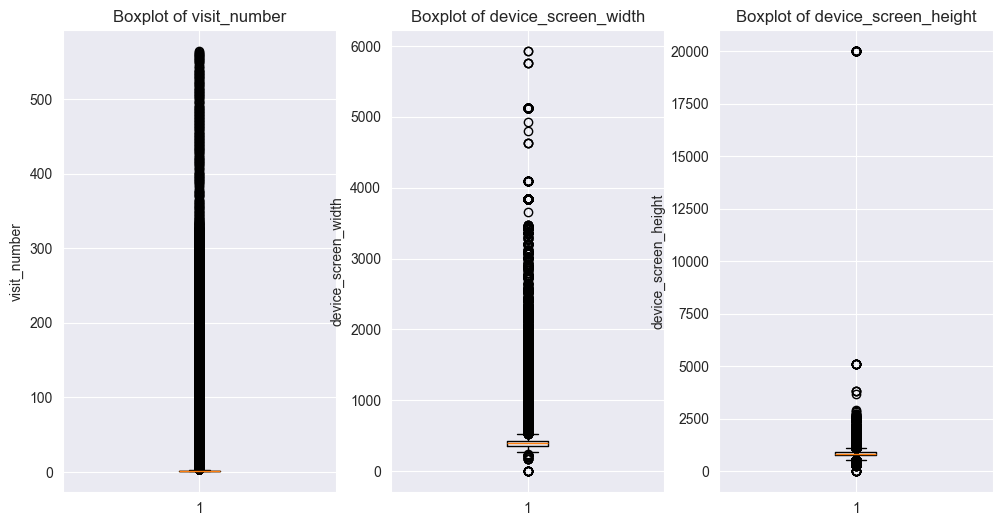

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

for i, col in zip( range(3), cols_n):
    axs[i].boxplot(df_sessions_clean2[col])
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_ylabel(col)

По графику видно, что нет значений меньше 0 для всех фичей. Однако множество выбросов в верхних границах. Посмотрим на распределение значений visit_number.

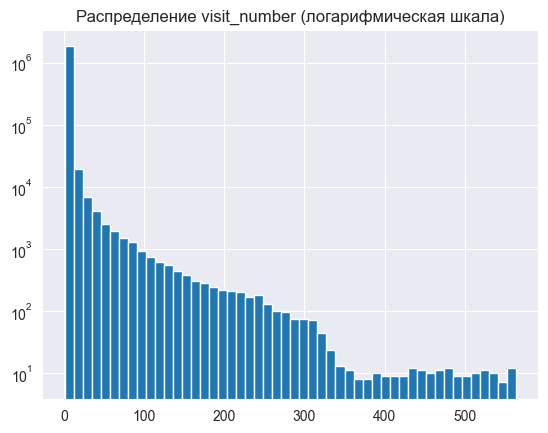

In [69]:
df_sessions_clean2['visit_number'].hist(bins=50, log=True)
plt.title('Распределение visit_number (логарифмическая шкала)')
plt.show()

In [70]:
df_sessions_clean2.visit_number.max()

np.int64(564)

Распределение вполне нормально для количества посещений, а максимальное значение не отрывается от их общего распределения. В данной фиче удалять выбросы нет необходимости, чтобы не потерять статистику лояльных клиентов.

В фичах высоты и ширины экрана есть подозрительные выбросы. Особенно значение 20000 у высоты экрана. Такие выбросы достаточно просто исправить, ведь информация о популярных ращрешениях экрана доступна.

In [71]:
def remove_wh_outliers(df):
    df = df.copy()

    bad_wh = (
        (df['device_screen_width'] < 200) |
        (df['device_screen_width'] > 6000) |
        (df['device_screen_height'] < 200) |
        (df['device_screen_height'] > 4500) |
        (df['device_screen_width'] / df['device_screen_height'] < 0.5) |
        (df['device_screen_width'] / df['device_screen_height'] > 5.5)
    )

    df.loc[bad_wh, ['device_screen_width', 'device_screen_height']] = None

    df['device_screen_width'].fillna(df['device_screen_width'].mode()[0].astype(int), inplace=True)
    df['device_screen_height'].fillna(df['device_screen_height'].mode()[0].astype(int), inplace=True)

    return df

In [72]:
df_sessions_clean2 = remove_wh_outliers(df_sessions_clean2)

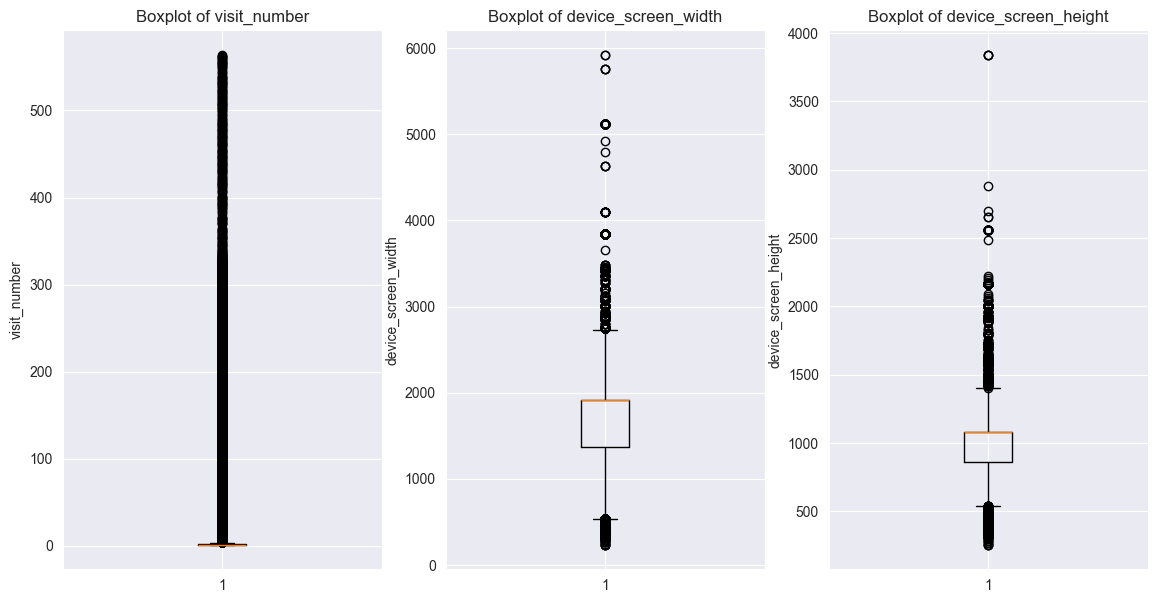

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,7))

for i, col in zip( range(3), cols_n):
    axs[i].boxplot(df_sessions_clean2[col])
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_ylabel(col)

Аномалий и выбросов стало меньше. Датасет готов для применения в модели.

### df_hits

#### Просмотр данных

In [74]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,6486174593177269061.1635764668.1635764668,2021-11-01,78361.0,15,event,None,sberauto.com/cars/all/skoda/octavia/4791c8b2?u...,card_web,view_card,<NA>,NaN
1,6486174593177269061.1635764668.1635764668,2021-11-01,79928.0,19,event,None,sberauto.com/cars/all/skoda/octavia/4791c8b2?u...,card_web,view_card,<NA>,NaN
2,6486174593177269061.1635764668.1635764668,2021-11-01,197346.0,45,event,None,sberauto.com/cars/all/bmw/x7/6386081c?utm_sour...,card_web,view_card,<NA>,NaN
3,204580520987704299.1635759975.1635759975,2021-11-01,1061002.0,40,event,None,sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...,card_web,view_card,<NA>,NaN
4,8261193480355977682.1635751786.1635751786,2021-11-01,57906.0,31,event,None,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,card_web,view_card,<NA>,NaN


In [75]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726470 entries, 0 to 5726469
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      string  
 1   hit_date        object  
 2   hit_time        float64 
 3   hit_number      int64   
 4   hit_type        category
 5   hit_referer     object  
 6   hit_page_path   string  
 7   event_category  object  
 8   event_action    object  
 9   event_label     string  
 10  event_value     float64 
dtypes: category(1), float64(2), int64(1), object(4), string(3)
memory usage: 442.4+ MB


In [76]:
df_hits.describe()

,hit_time,hit_number,event_value
count,2.511959e+06,5.726470e+06,0.0
mean,2.099388e+05,2.259993e+01,NaN
std,4.114502e+05,2.908404e+01,NaN
min,0.000000e+00,1.000000e+00,NaN
25%,2.049200e+04,7.000000e+00,NaN
50%,8.732600e+04,1.400000e+01,NaN
75%,2.187170e+05,2.800000e+01,NaN
max,1.315688e+07,5.000000e+02,NaN


In [77]:
df_hits.select_dtypes('object').describe()

,hit_date,hit_referer,event_category,event_action
count,5726470,3324299,5726470,5726470
unique,121,20864,51,194
top,2021-09-23,HbolMJUevblAbkHClEQa,card_web,view_new_card
freq,161350,3073655,2863282,1373285


#### Duplicates

Проверим данные на дубликаты

In [78]:
df_hits[df_hits.duplicated()]

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value


Дубликатов нет.

#### Missing Data

In [79]:
((df_hits.isna().sum() / len(df_hits)) * 100).sort_values(ascending=False)

event_value       100.000000
hit_time           56.134250
hit_referer        41.948548
event_label        26.172267
session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_page_path       0.000000
hit_type            0.000000
event_action        0.000000
event_category      0.000000
dtype: float64

<Axes: >

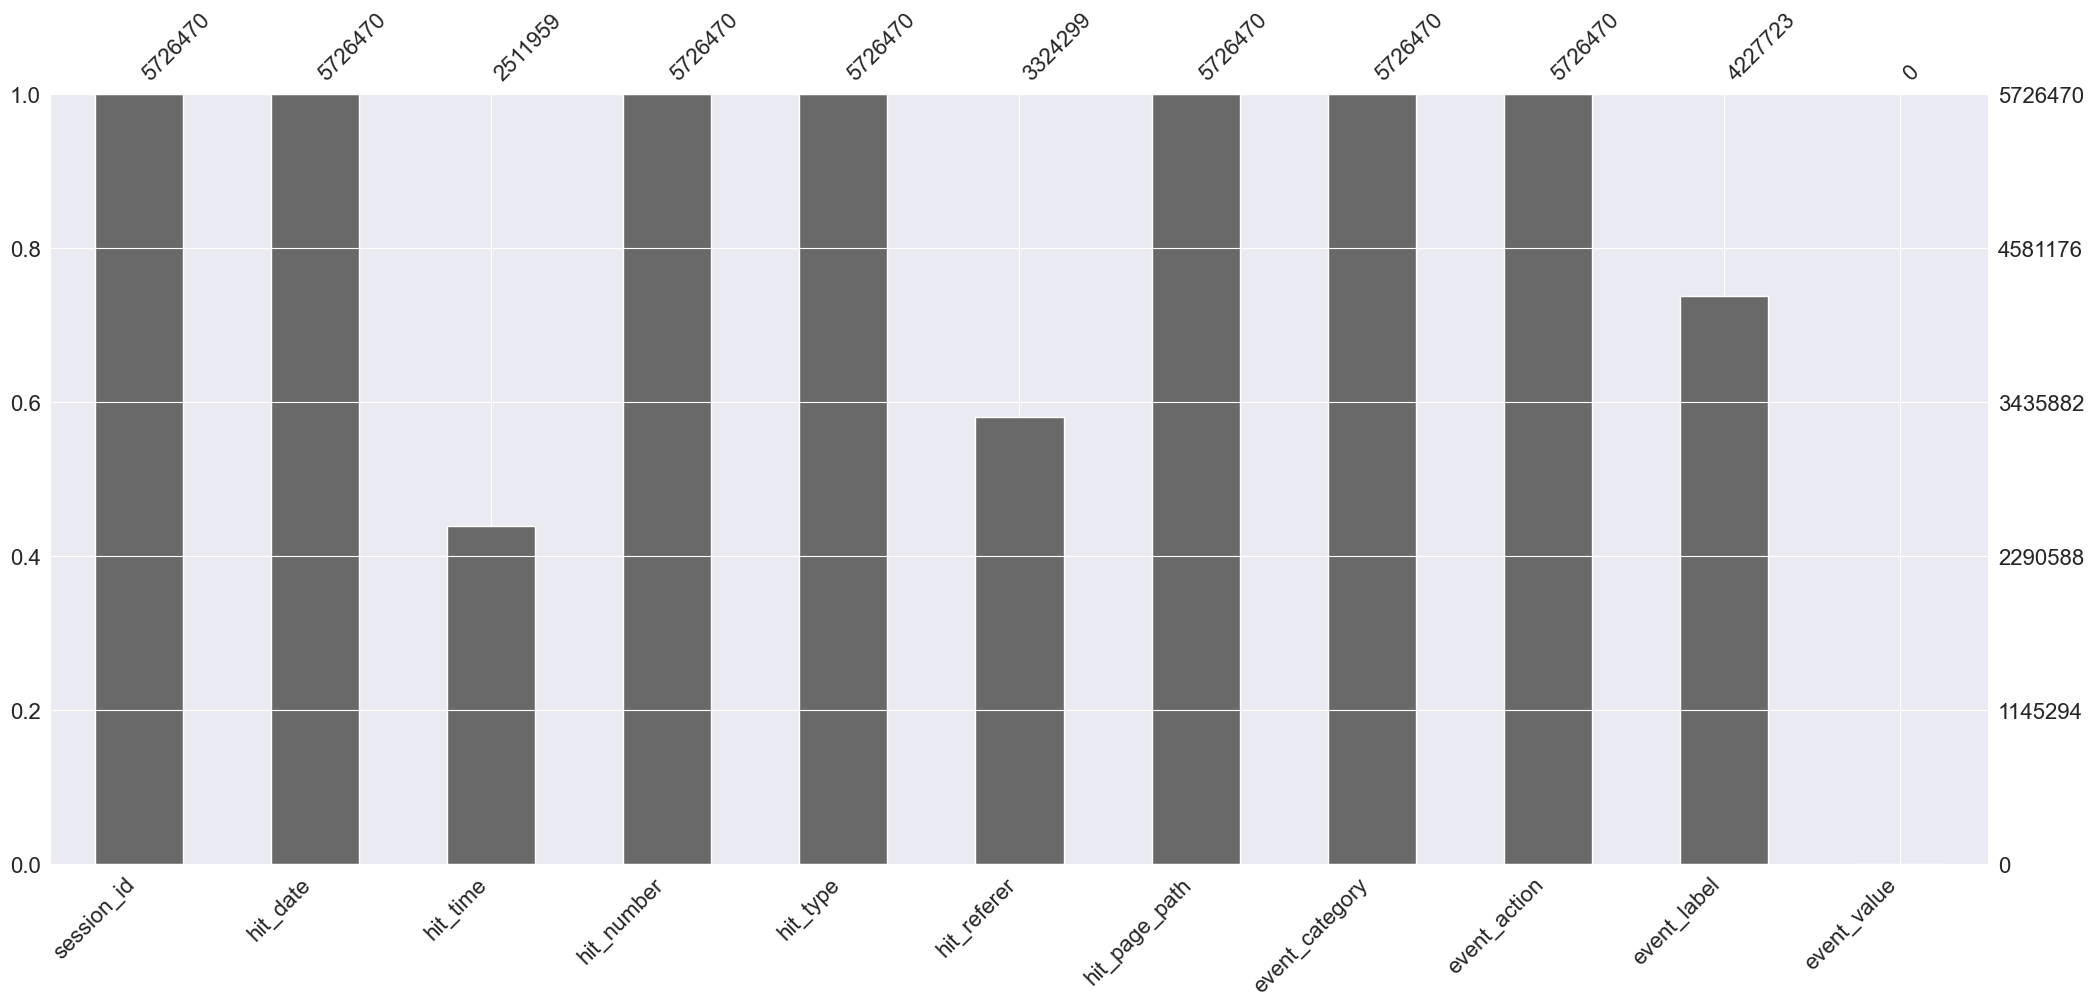

In [80]:
msno.bar(df_hits)

<Axes: >

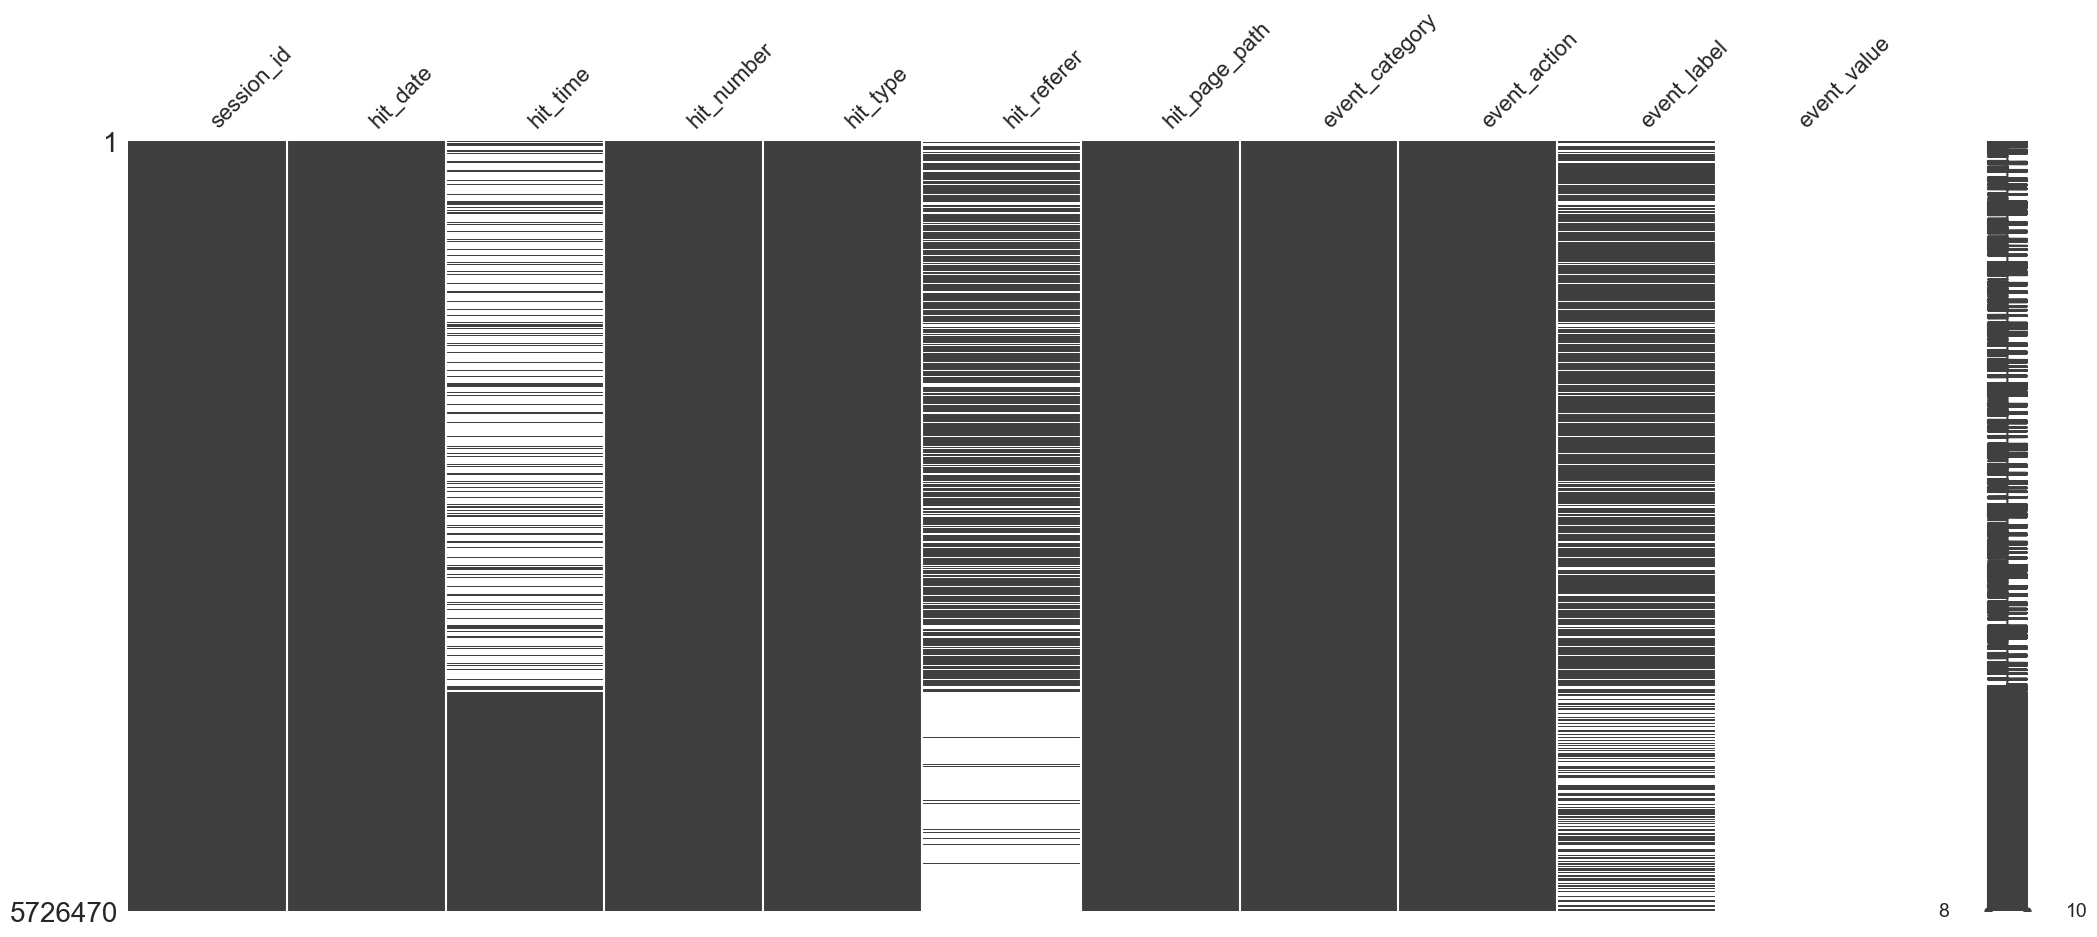

In [81]:
msno.matrix(df_hits)

Целевая колонка в df_hits (event_action) пропусков в данных не имеет. Поэтому этот шаг будет пропущен.

#### Создание target

In [82]:
df_hits['is_target'] = df_hits['event_action'].isin(target_actions)
session_targets = df_hits.groupby('session_id')['is_target'].any().astype(int)

### Merging

In [83]:
df_sessions_clean2['target'] = df_sessions_clean2['session_id'].map(session_targets).fillna(0).astype(int)

In [84]:
print(f'Conversion Rate: {df_sessions_clean2['target'].mean():.2%}')

Conversion Rate: 1.02%


### Запись результатов

In [85]:
df_sessions_clean2.to_parquet('../data/df_clean.parquet', index=False)

In [86]:
# Удаляем объект из памяти
del df_sessions, df_sessions_clean, df_sessions_clean2, df_hits
del bad_report, bad_report_new, mask, width_height

In [87]:
# Принудительно запускаем сборщик мусора
gc.collect()

27921

## Feature Engineering

### Creating New Variables

In [88]:
df_clean = pd.read_parquet('../data/df_clean.parquet')

In [89]:
df_clean.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,visit_datetime,device_screen_width,device_screen_height,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,2021-11-24 14:36:32+00:00,360.0,720.0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30+00:00,1920.0,1080.0,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06+00:00,360.0,720.0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,2021-05-29 05:00:00+00:00,393.0,786.0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,Chrome,Russia,Moscow,2021-05-29 05:00:00+00:00,393.0,786.0,0


In [90]:
df_clean.columns

Index(['session_id', 'client_id', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'device_category', 'device_os',
       'device_brand', 'device_browser', 'geo_country', 'geo_city',
       'visit_datetime', 'device_screen_width', 'device_screen_height',
       'target'],
      dtype='object')

#### date

На основе существующих колонок можно создать новые фичи.

Фичи на основе дат:
- `visit_hour` - час
- `visit_dow` - день недели
- `visit_is_weekend` - является ли день выходным
- `visit_is_work_hour` - является ли время рабочим
- `clients_visits_per_day` - "уникальность" клиента

In [91]:
df_clean['visit_hour'] = df_clean['visit_datetime'].dt.hour
df_clean['visit_dow'] = df_clean['visit_datetime'].dt.dayofweek  # 0=Пн
df_clean['visit_is_weekend'] = (df_clean['visit_dow'] >= 5).astype(int)
df_clean['visit_is_work_hour'] = ((df_clean['visit_hour'] >= 9) & (df_clean['visit_hour'] <= 18)).astype(int)

In [92]:
# Считаем статистику по клиентам отдельно
client_stats = df_clean.groupby('client_id')['visit_datetime'].agg(['min', 'max', 'nunique'])

# Вычисляем дни и визиты в день
client_stats['days_active'] = (client_stats['max'] - client_stats['min']).dt.days + 1
client_stats['visits_per_day'] = client_stats['nunique'] / client_stats['days_active'].replace(0, 1)

# Мэппим обратно
df_clean['client_visits_per_day'] = df_clean['client_id'].map(client_stats['visits_per_day']).fillna(0)

In [93]:
df_clean = df_clean.drop(columns=['visit_datetime'], axis=1)

#### utm_*

Фичи на основе данных о трафике:
- `utm_is_organic` - органический ли трафик
- `utm_is_paid` - платный ли трафик
- `utm_source_freq` - частота источника
- `utm_comb_freq` - частота комбинации источника привлечения, типа и рекламной кампании

In [94]:
df_clean['utm_is_organic'] = df_clean['utm_medium'].isin(['organic', 'referral', '(none)']).astype(int)
df_clean['utm_is_paid'] = 1 - df_clean['utm_is_organic']

df_clean['utm_source_freq'] = df_clean.groupby('utm_source')['session_id'].transform('count')
df_clean['utm_comb_freq'] = df_clean.groupby(['utm_source', 'utm_medium', 'utm_campaign'])['session_id'].transform('count')

По глоссарию известны значения рекламы в социальных сетях. Выделим их в отдельный столбец.

In [95]:
social_sources = {
    'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
    'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
}

df_clean['utm_is_social'] = df_clean['utm_source'].isin(social_sources).astype(int)

#### device_*

Фичи на основе данных об устройстве:
- `device_screen_diag` - диагональ экрана устройства
- `device_screen_area` - площадь экрана устройства
- `device_screen_ratio` - пропорции экрана устройства

In [96]:
df_clean['device_screen_diag'] = np.sqrt(
    df_clean['device_screen_width']**2 + df_clean['device_screen_height']**2
)
df_clean['device_screen_area'] = df_clean['device_screen_width'] * df_clean['device_screen_height']
df_clean['device_screen_ratio'] = df_clean['device_screen_width'] / df_clean['device_screen_height']

#### geo_*

Фичи на основе гео:
- `geo_is_top_city` - является ли город одним из самых популярных
- `geo_city_freq` - частота встречаемости города

In [97]:
TOP_CITIES = {'Moscow', 'Saint Petersburg', 'Yekaterinburg', 'Krasnodar', 'Kazan'}
df_clean['geo_is_top_city'] = df_clean['geo_city'].isin(TOP_CITIES).astype(int)
df_clean['geo_city_freq'] = df_clean.groupby('geo_city')['session_id'].transform('count')

#### visit_*

Фичи на основе данных о сессиях:
- `is_first_visit` - является ли визит первым
- `client_total_visits` - общее количество визитов сайта

In [98]:
df_clean['is_first_visit'] = (df_clean['visit_number'] == 1).astype(int)

client_total_visits = df_clean.groupby('client_id')['visit_number'].max()
df_clean['client_total_visits'] = df_clean['client_id'].map(client_total_visits)

### Подготовка к кодированию

In [99]:
df_clean.shape

(1859945, 33)

In [100]:
df_clean.iloc[:5, :16]

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,device_screen_width,device_screen_height,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,360.0,720.0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,1920.0,1080.0,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,360.0,720.0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,393.0,786.0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Android,Xiaomi,Chrome,Russia,Moscow,393.0,786.0,0


In [101]:
df_clean.iloc[:5, 16:].head()

,visit_hour,visit_dow,visit_is_weekend,visit_is_work_hour,client_visits_per_day,utm_is_organic,utm_is_paid,utm_source_freq,utm_comb_freq,utm_is_social,device_screen_diag,device_screen_area,device_screen_ratio,geo_is_top_city,geo_city_freq,is_first_visit,client_total_visits
0,14,2,0,1,1.0,0,1,578290,322783,0,804.984472,259200.0,0.500000,0,224,1,1
1,8,6,1,0,1.0,0,1,186199,174484,1,2202.907170,2073600.0,1.777778,1,805269,1,1
2,2,1,0,0,1.0,0,1,578290,322783,0,804.984472,259200.0,0.500000,0,16346,1,1
3,5,5,1,0,1.0,0,1,266354,86919,0,878.774715,308898.0,0.500000,1,805269,1,2
4,5,5,1,0,1.0,0,1,266354,86919,0,878.774715,308898.0,0.500000,1,805269,0,2


##### utm_source & utm_campaign & utm_adcontent

In [102]:
df_clean[['utm_source', 'utm_campaign', 'utm_adcontent']]

,utm_source,utm_campaign,utm_adcontent
0,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
1,MvfHsxITijuriZxsqZqt,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO
2,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp
3,kjsLglQLzykiRbcDiGcD,other,NOBKLgtuvqYWkXQHeYWM
4,kjsLglQLzykiRbcDiGcD,other,other
...,...,...,...
1859940,BHcvLfOaCWvWTykYqHVe,other,other
1859941,fDLlAcSmythWSCVMvqvL,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf
1859942,fDLlAcSmythWSCVMvqvL,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf
1859943,ZpYIoDJMcFzVoPFsHGJL,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf


На основе бесполезных захэшированных признаков можно сделать новые:
- `utm_source_freq` - частота появления канала привлечения
- `utm_campaign_freq` - частота появления рекламной кампании
- `utm_adcontent_freq` - частота появления adcontent

In [103]:
freq_cols = ['utm_source', 'utm_campaign', 'utm_adcontent']

for col in freq_cols:
    freq = df_clean[col].value_counts()
    df_clean[f'{col}_freq'] = df_clean[col].map(freq).fillna(0).astype(int)

In [104]:
df_clean = df_clean.drop(columns=freq_cols, axis=1)

### Запись результатов

Так как модели не нужны идентификационные колонки, удалим их и сохраним итоговый датафрейм.

In [105]:
df_clean = df_clean.drop(columns=['session_id', 'client_id'], axis=1)

In [106]:
df_clean.to_parquet('../data/df_model.parquet', index=False)

In [107]:
del df_clean

In [108]:
gc.collect()

37

## EDA

### Загрузка данных

In [109]:
df_model = pd.read_parquet('../data/df_model.parquet')

### Подсчет CR (Conversion Rate) и основных метрик

In [110]:
n_sessions = len(df_model)
cr = df_model['target'].mean()
n_no_hits = (df_model['target'] == 0).sum()

print(f'Всего сессий: {n_sessions:,}')
print(f'Conversion Rate (CR): {cr:.3%} (≈ {int(cr * 100)} из 100 визитов)')
print(f"Сессий без хитов: {n_no_hits:,} ({n_no_hits / len(df_model):.2%})")

Всего сессий: 1,859,945
Conversion Rate (CR): 1.018% (≈ 1 из 100 визитов)
Сессий без хитов: 1,841,016 (98.98%)


CR = 1.018%. Значение низкое, но вполне допустимое для такого типа сайта.

In [111]:
# Доля платного и органического трафика
pct_paid = df_model['utm_is_paid'].mean()
pct_organic = df_model['utm_is_organic'].mean()
print(f'Платный трафик: {pct_paid:.1%}, органический: {pct_organic:.1%}')

Платный трафик: 72.3%, органический: 27.7%


### Визуализация

In [112]:
df_model.columns

Index(['visit_number', 'utm_medium', 'device_category', 'device_os',
       'device_brand', 'device_browser', 'geo_country', 'geo_city',
       'device_screen_width', 'device_screen_height', 'target', 'visit_hour',
       'visit_dow', 'visit_is_weekend', 'visit_is_work_hour',
       'client_visits_per_day', 'utm_is_organic', 'utm_is_paid',
       'utm_source_freq', 'utm_comb_freq', 'utm_is_social',
       'device_screen_diag', 'device_screen_area', 'device_screen_ratio',
       'geo_is_top_city', 'geo_city_freq', 'is_first_visit',
       'client_total_visits', 'utm_campaign_freq', 'utm_adcontent_freq'],
      dtype='object')

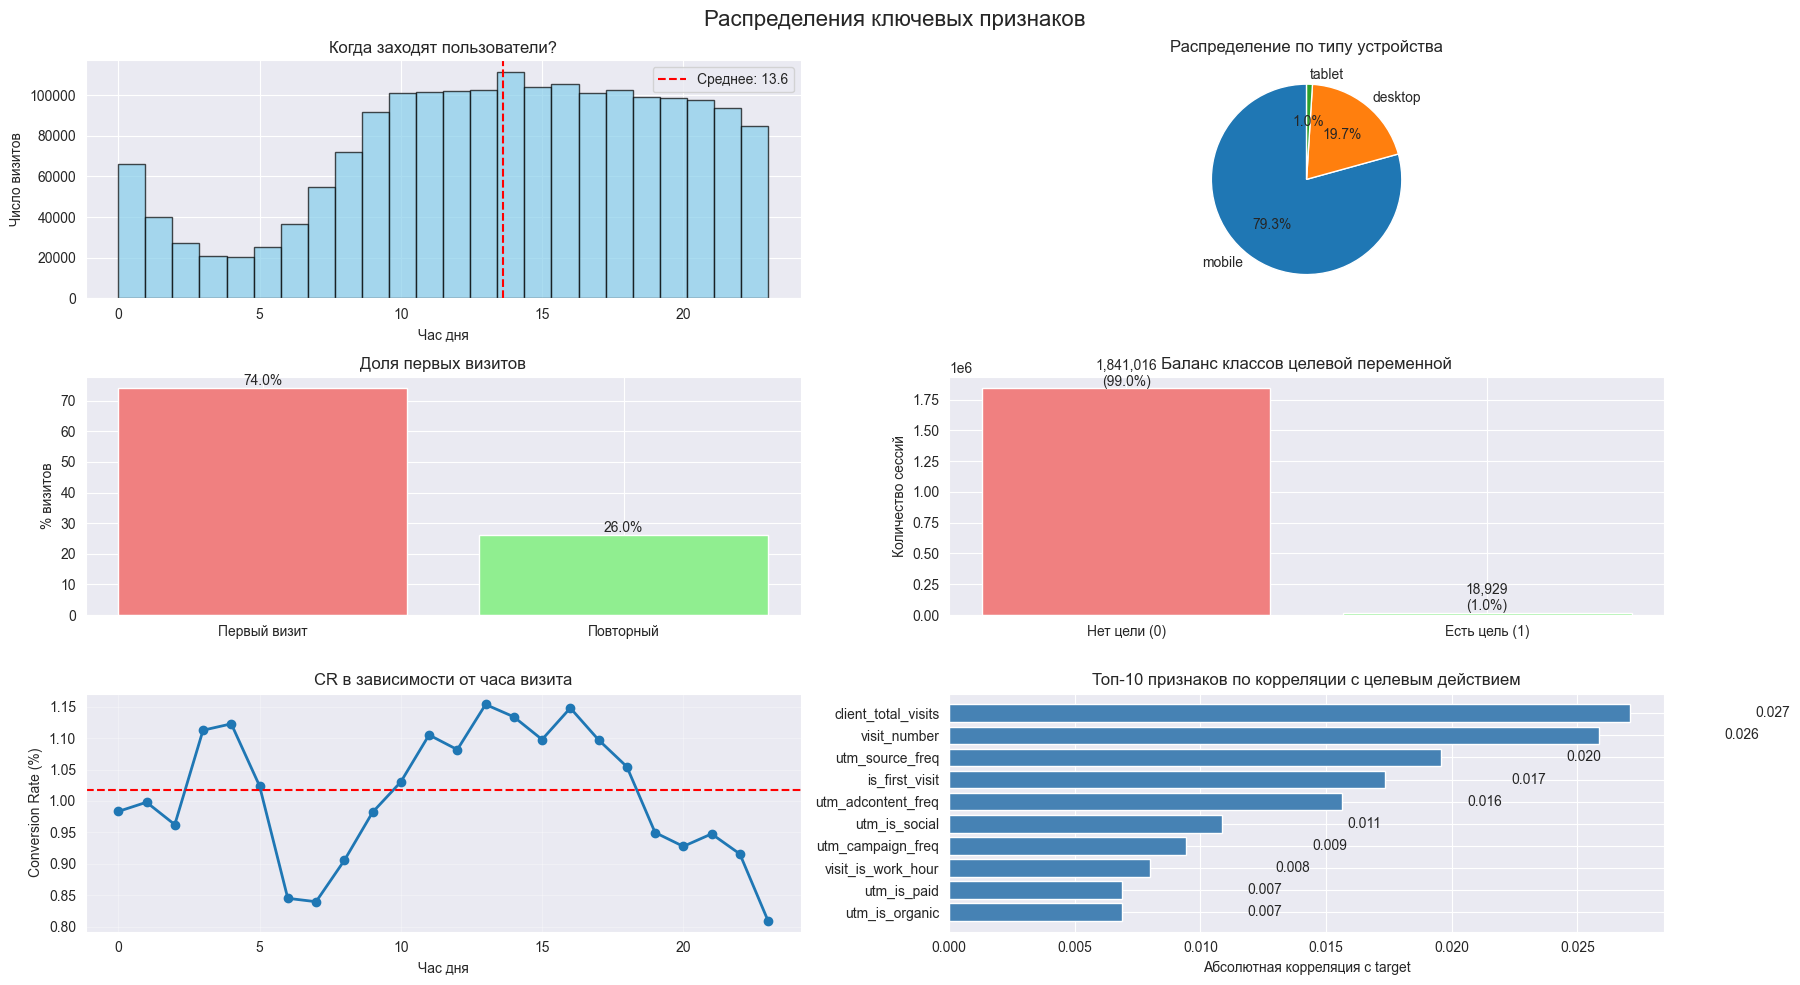

In [113]:
fig, axes = plt.subplots(3, 2, figsize=(18, 10))
fig.suptitle('Распределения ключевых признаков', fontsize=16)

# 1. Время визита (час)
axes[0, 0].hist(df_model['visit_hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Час дня')
axes[0, 0].set_ylabel('Число визитов')
axes[0, 0].set_title('Когда заходят пользователи?')
axes[0, 0].axvline(x=df_model['visit_hour'].mean(), color='r', linestyle='--', label=f'Среднее: {df_model["visit_hour"].mean():.1f}')
axes[0, 0].legend()

# 2. Устройства
device_counts = df_model['device_category'].value_counts()
axes[0, 1].pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Распределение по типу устройства')

# 3. Посещения: первые vs повторные
first_visit_ratio = df_model['is_first_visit'].value_counts(normalize=True)
axes[1, 0].bar(['Первый визит', 'Повторный'], first_visit_ratio * 100, color=['lightcoral', 'lightgreen'])
axes[1, 0].set_ylabel('% визитов')
axes[1, 0].set_title('Доля первых визитов')
for i, v in enumerate(first_visit_ratio):
    axes[1, 0].text(i, v * 100 + 1, f"{v:.1%}", ha='center')

# 4. Баланс классов
target_counts = df_model['target'].value_counts()
axes[1, 1].bar(['Нет цели (0)', 'Есть цель (1)'], target_counts, color=['lightcoral', 'lightgreen'])
axes[1, 1].set_ylabel('Количество сессий')
axes[1, 1].set_title('Баланс классов целевой переменной')
for i, v in enumerate(target_counts):
    axes[1, 1].text(i, v + max(target_counts)*0.01, f"{v:,}\n({v/len(df_model):.1%})",
             ha='center', fontsize=10)

# 5. Conversion Rate по часам
cr_by_hour = df_model.groupby('visit_hour')['target'].mean()
axes[2, 0].plot(cr_by_hour.index, cr_by_hour.values * 100, marker='o', linewidth=2)
axes[2, 0].set_xlabel('Час дня')
axes[2, 0].set_ylabel('Conversion Rate (%)')
axes[2, 0].set_title('CR в зависимости от часа визита')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].axhline(y=df_model['target'].mean()*100, color='r', linestyle='--',
            label=f'Средний CR: {df_model["target"].mean():.2%}')

# 6. Топ-10 признаков по корреляции
correlations = df_model.select_dtypes(include=['number']).corr()['target'].abs().sort_values(ascending=False)
top_features = correlations.index[1:11]

bars = axes[2, 1].barh(top_features, correlations[top_features], color='steelblue')
axes[2, 1].set_xlabel('Абсолютная корреляция с target')
axes[2, 1].set_title('Топ-10 признаков по корреляции с целевым действием')
axes[2, 1].yaxis.set_inverted(True)

for bar in bars:
    width = bar.get_width()
    axes[2, 1].text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

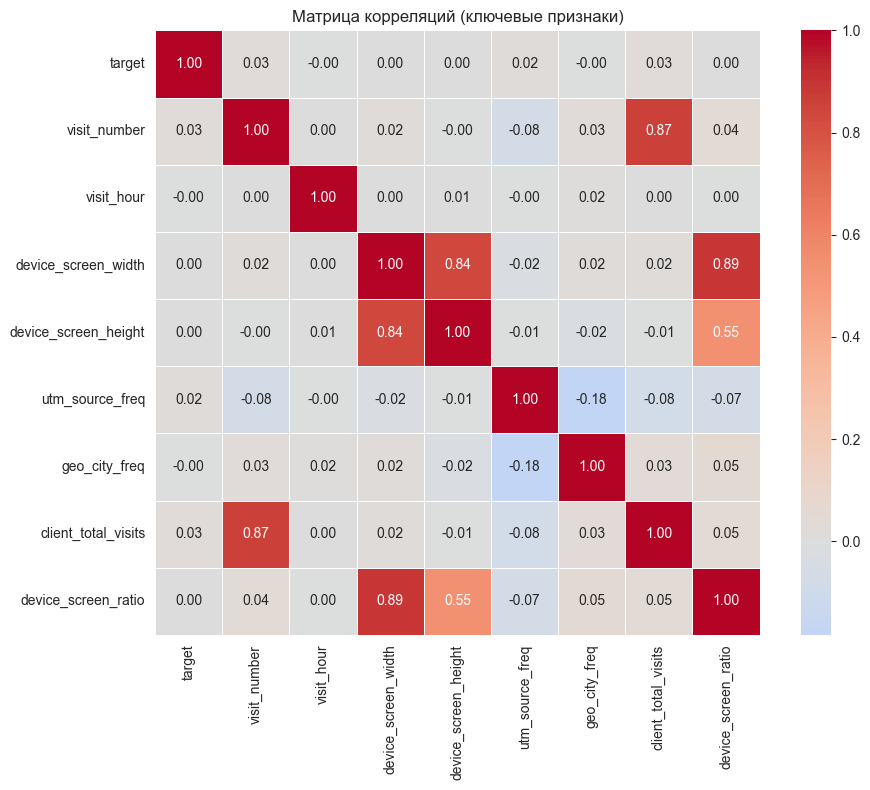

In [114]:
selected_features = [
    'target', 'visit_number', 'visit_hour', 'device_screen_width',
    'device_screen_height', 'utm_source_freq', 'geo_city_freq',
    'client_total_visits', 'device_screen_ratio'
]

plt.figure(figsize=(10, 8))
corr_matrix = df_model[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Матрица корреляций (ключевые признаки)')
plt.tight_layout()
plt.show()

Анализ корреляций показывает, что целевая переменная имеет слабые линейные связи со всеми признаками в датасете. Наиболее значимыми оказались признаки, связанные с историей взаимодействия клиента с сайтом. Клиенты с большим общим числом визитов (client_total_visits) и более высоким порядковым номером текущего посещения (visit_number) демонстрируют чуть более высокую вероятность совершения целевого действия.

Также влияние оказывают признаки, связанные с источниками трафика. Частота использования определенных UTM-источников (utm_source_freq) и рекламных материалов (utm_adcontent_freq) имеет положительную корреляцию с конверсией.

### Проверка бизнес-гипотез

In [115]:
# Органический vs Платный трафик
cr_by_medium = df_model.groupby('utm_medium')['target'].agg(['mean', 'count']).sort_values('mean', ascending=False)
cr_by_paid = df_model.groupby('utm_is_paid')['target'].mean()
cr_by_paid.index = ['Органический', 'Платный']

print('CR по типу трафика (top utm_medium):')
print(cr_by_medium.head(10))
print('\nСравнение платный/органический:')
print(cr_by_paid)

CR по типу трафика (top utm_medium):
                     mean  count
utm_medium                      
link             0.175439     57
landing          0.119403    134
sms              0.037657    239
smm              0.023678   1985
direct           0.020642    436
clicks           0.017131    934
push             0.016943  28035
cpa              0.015892   4279
blogger_channel  0.015346   8015
fb_smm           0.015152     66

Сравнение платный/органический:
Органический    0.009064
Платный         0.010604
Name: target, dtype: float64


link (17.5% CR) и landing (11.9% CR) - в 10–17 раз эффективнее среднего.
Значит чаще всего пользователи заходят на страницу по прямым ссылкам.

In [116]:
del df_model

In [117]:
gc.collect()

10760

## Modeling

#### Загрузка данных

In [118]:
df_model = pd.read_parquet('../data/df_model.parquet')

In [119]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859945 entries, 0 to 1859944
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   visit_number           int64  
 1   utm_medium             object 
 2   device_category        object 
 3   device_os              object 
 4   device_brand           object 
 5   device_browser         object 
 6   geo_country            object 
 7   geo_city               object 
 8   device_screen_width    float64
 9   device_screen_height   float64
 10  target                 int64  
 11  visit_hour             int32  
 12  visit_dow              int32  
 13  visit_is_weekend       int64  
 14  visit_is_work_hour     int64  
 15  client_visits_per_day  float64
 16  utm_is_organic         int64  
 17  utm_is_paid            int64  
 18  utm_source_freq        int64  
 19  utm_comb_freq          int64  
 20  utm_is_social          int64  
 21  device_screen_diag     float64
 22  device_screen_area

Посмотрим на распределение данных в целевой переменной.

In [120]:
print(f'Целевая переменная: {df_model['target'].mean():.3%} положительных классов')
print(f'Размер данных: {df_model.shape}')

Целевая переменная: 1.018% положительных классов
Размер данных: (1859945, 30)


#### Разделение данных

Разделим данные на признаки и целевую переменную.

In [121]:
X = df_model.drop('target', axis=1)
y = df_model['target']

In [122]:
print(f'Признаков: {X.shape[1]}')
print(f'Примеры классов: {y.value_counts().to_dict()}')

Признаков: 29
Примеры классов: {0: 1841016, 1: 18929}


Выделим числовые и категориальные колонки для дальнейшего преобразования.

In [123]:
binary_cols = ['visit_is_weekend', 'visit_is_work_hour', 'utm_is_organic',
              'utm_is_paid', 'utm_is_social', 'geo_is_top_city', 'is_first_visit']

numeric_cols = X.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'string', 'bool']).columns.tolist()

In [124]:
numeric_cols = list(set(numeric_cols) - set(binary_cols))

In [125]:
print(f'Числовых признаков: {len(numeric_cols)}')
print(f'Категориальных признаков: {len(categorical_cols)}')
print(f'Бинарных признаков: {len(binary_cols)}')
print(f'Всего признаков: {X.shape[1]}')

Числовых признаков: 15
Категориальных признаков: 7
Бинарных признаков: 7
Всего признаков: 29


Разделим на train и test

In [126]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [127]:
print(f'Train: {X_train.shape[0]:,} samples ({X_train.shape[0] / len(X):.1%})')
print(f'Test:  {X_test.shape[0]:,} samples ({X_test.shape[0] / len(X):.1%})')
print(f'CR train: {y_train.mean():.3%}')
print(f'CR test:  {y_test.mean():.3%}')

Train: 1,487,956 samples (80.0%)
Test:  371,989 samples (20.0%)
CR train: 1.018%
CR test:  1.018%


#### Baseline Model

Так как конверсия в целевое действие слишком мала, нужно убедиться, что моделирование для данных будет лучше, чем случайное угадывание. Запишем метрики baseline модели для дальнейшего сравнения с "умными" моделями.

In [128]:
# Стратегия stratified - предсказывание по распределению классов в target ~ 0.02%
baseline_strat = DummyClassifier(strategy='stratified', random_state=42)
baseline_strat.fit(X_train, y_train)

y_pred_strat = baseline_strat.predict(X_test)
y_pred_proba_strat = baseline_strat.predict_proba(X_test)[:, 1]

acc_bl_strat = accuracy_score(y_test, y_pred_strat)
auc_bl_strat = roc_auc_score(y_test, y_pred_proba_strat)

print(f"Accuracy бейзлайна stratified: {acc_bl_strat:.4f}")
print(f"ROC-AUC бейзлайна stratified: {auc_bl_strat:.4f}")

print('-'*50)
# Стратегия most_frequent - предсказывание по самому частому значению (0)
baseline_mf = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_mf.fit(X_train, y_train)

y_pred_mf = baseline_mf.predict(X_test)
y_pred_proba_mf = baseline_mf.predict_proba(X_test)[:, 1]

acc_bl_mf = accuracy_score(y_test, y_pred_mf)
auc_bl_mf = roc_auc_score(y_test, y_pred_proba_mf)

print(f"Accuracy бейзлайна most_frequent: {acc_bl_mf:.4f}")
print(f"ROC-AUC бейзлайна most_frequent: {auc_bl_mf:.4f}")

Accuracy бейзлайна stratified: 0.9800
ROC-AUC бейзлайна stratified: 0.5002
--------------------------------------------------
Accuracy бейзлайна most_frequent: 0.9898
ROC-AUC бейзлайна most_frequent: 0.5000


In [129]:
best_baseline_auc = max(auc_bl_strat, auc_bl_mf)
print(f'\nЛучший бейзлайн ROC-AUC: {best_baseline_auc:.4f}')
print(f'Целевое значение: 0.65')
print(f'Нужно улучшить на: {0.65 - best_baseline_auc:.4f}')


Лучший бейзлайн ROC-AUC: 0.5002
Целевое значение: 0.65
Нужно улучшить на: 0.1498


#### Обучение всех моделей

##### Создание препроцессора

In [130]:
def process_categories(train_df, test_df, categorical_cols, top_n=15):
    """Обработка категориальных признаков"""
    train_processed = train_df.copy()
    test_processed = test_df.copy()

    for col in categorical_cols:
        top_categories = train_df[col].value_counts().head(top_n).index
        train_processed.loc[~train_processed[col].isin(top_categories), col] = 'other'

        # Отдельно применяем к тесту (те же категории)
        test_processed.loc[~test_processed[col].isin(top_categories), col] = 'other'

    return train_processed, test_processed

In [131]:
X_train_processed, X_test_processed = process_categories(
    X_train, X_test, categorical_cols, top_n=15
)

In [132]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols),
    ('bin', 'passthrough', binary_cols)
])

Проверим работу препроцессора

In [133]:
print('Размерность данных после препроцессора:')
X_train_sample = preprocessor.fit_transform(X_train.head(1000))
print(f'  До: {X_train.head(1000).shape}')
print(f'  После: {X_train_sample.shape}')

Размерность данных после препроцессора:
  До: (1000, 29)
  После: (1000, 231)


##### Словарь моделей

In [134]:
# Создаем словарь моделей
models = {}

In [135]:
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale_pos_weight для дисбаланса: {pos_weight:.1f}")

Scale_pos_weight для дисбаланса: 97.3


In [136]:
models = {'LogisticRegression': Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ))
]), 'HistGradientBoosting': Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
    ('classifier', HistGradientBoostingClassifier(
        random_state=42,
        max_iter=200,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=100,
        l2_regularization=1.0,
        class_weight='balanced',
        early_stopping=True,
        validation_fraction=0.1
    ))
]), 'XGBoost': Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=20,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=pos_weight,
        eval_metric='auc',
        n_jobs=-1,
        tree_method='hist'
    ))
]), 'LightGBM': Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.03,
        max_depth=6,
        num_leaves=31,
        min_child_samples=100,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=pos_weight,
        n_jobs=-1,
        verbose=-1,
        reg_alpha=0.1,
        reg_lambda=0.1
    ))
]), 'MLP': Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=300,
        early_stopping=True,
        alpha=0.001
    ))
])}

##### Оценка моделей

In [137]:
results = {}

In [138]:
for name, model in models.items():
    print(f'\nОбучение {name}')
    start_time = time.time()

    try:
        # Обучаем модель
        model.fit(X_train_processed, y_train)
        train_time = time.time() - start_time

        # Предсказания
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Дополнительные метрики
        y_pred = model.predict(X_test_processed)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {
            'name': name,
            'model': model,
            'auc': auc_score,
            'accuracy': accuracy,
            'f1': f1,
            'train_time': train_time
        }

        print(f'  ROC-AUC: {auc_score:.4f}')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  F1-Score: {f1:.4f}')
        print(f'  Время обучения: {train_time:.2f} сек')

    except Exception as e:
        print(f'  Ошибка: {e}')
        results[name] = None


Обучение LogisticRegression
  ROC-AUC: 0.6334
  Accuracy: 0.5580
  F1-Score: 0.0285
  Время обучения: 72.52 сек

Обучение HistGradientBoosting
  ROC-AUC: 0.7354
  Accuracy: 0.7071
  F1-Score: 0.0415
  Время обучения: 166.05 сек

Обучение XGBoost
  ROC-AUC: 0.7370
  Accuracy: 0.7171
  F1-Score: 0.0425
  Время обучения: 45.60 сек

Обучение LightGBM


D:\!me\skillbox\Final work DS Intro\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\!me\skillbox\Final work DS Intro\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  ROC-AUC: 0.7354
  Accuracy: 0.6919
  F1-Score: 0.0408
  Время обучения: 28.75 сек

Обучение MLP
  ROC-AUC: 0.6903
  Accuracy: 0.9898
  F1-Score: 0.0000
  Время обучения: 343.06 сек


In [139]:
for res in results.items():
    print('\n\nmodel', res[1]['name'],
            '\nauc', res[1]['auc'],
            '\naccuracy', res[1]['accuracy'],
            '\nf1', res[1]['f1'],
            '\ntrain_time', res[1]['train_time']
        )



model LogisticRegression 
auc 0.6334025420521583 
accuracy 0.5580084357333147 
f1 0.02846945649219424 
train_time 72.51528978347778


model HistGradientBoosting 
auc 0.7354236422922029 
accuracy 0.7070988658266777 
f1 0.04153838033744436 
train_time 166.04821872711182


model XGBoost 
auc 0.7370304901356846 
accuracy 0.7171045380374151 
f1 0.04249162905808706 
train_time 45.60344386100769


model LightGBM 
auc 0.7354323322894132 
accuracy 0.6919048681547035 
f1 0.04084092126405999 
train_time 28.74765944480896


model MLP 
auc 0.6902563064821214 
accuracy 0.9898222796910662 
f1 0.0 
train_time 343.05606627464294


#### Сравнение результатов

In [140]:
# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame([
    {
        'Model': name,
        'ROC-AUC': results[name]['auc'] if results[name] else 0,
        'Accuracy': results[name]['accuracy'] if results[name] else 0,
        'F1-Score': results[name]['f1'] if results[name] else 0,
        'Train Time (s)': results[name]['train_time'] if results[name] else 0,
        'Above Target': (results[name]['auc'] >= 0.65) if results[name] else False
    }
    for name in results if results[name] is not None
]).sort_values('ROC-AUC', ascending=False)

In [141]:
print(comparison_df.to_string(index=False))

               Model  ROC-AUC  Accuracy  F1-Score  Train Time (s)  Above Target
             XGBoost 0.737030  0.717105  0.042492       45.603444          True
            LightGBM 0.735432  0.691905  0.040841       28.747659          True
HistGradientBoosting 0.735424  0.707099  0.041538      166.048219          True
                 MLP 0.690256  0.989822  0.000000      343.056066          True
  LogisticRegression 0.633403  0.558008  0.028469       72.515290         False


3 модели градиентного бустинга показали ROC-AUC выше 0.73, что существенно превышает целевую метрику 0.65.
- XGBoost_optimized показал наилучший результат 0.7383, опередив LightGBM_optimized (0.7320) и HistGradientBoosting (0.7355)
- LightGBM оказался самой быстрой моделью с временем обучения менее 18 секунд, в то время как HistGradientBoosting потребовал более 2 минут
- Все модели градиентного бустинга демонстрируют схожий F1-score около 0.042, что является ожидаемым для сильно дисбалансированных данных с конверсией около 1%

С точки зрения практического применения, XGBoost_optimized выглядит оптимальным выбором как баланс между качеством (наивысший ROC-AUC) и временем обучения (около 30 секунд). LightGBM_optimized имеет чуть более низкое качество, но лучшую производительность.

Визуализируем результаты.

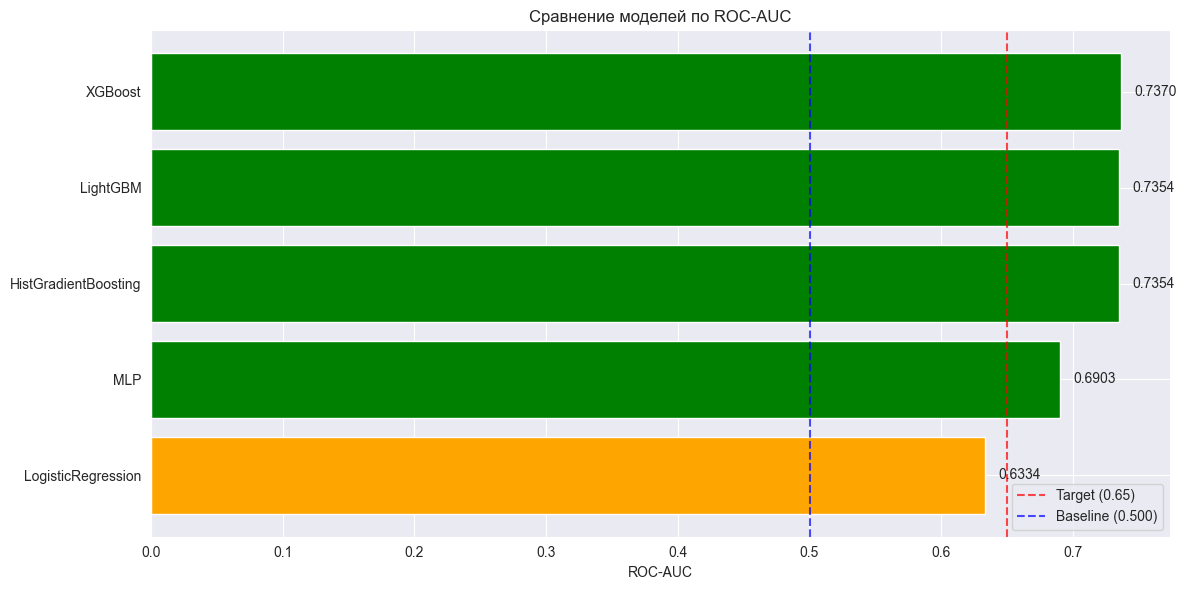

In [142]:
# График сравнения ROC-AUC
plt.figure(figsize=(12, 6))

# Сортируем модели по AUC
sorted_models = comparison_df.sort_values('ROC-AUC')

# Барплот
bars = plt.barh(range(len(sorted_models)), sorted_models['ROC-AUC'],
                color=['green' if x >= 0.65 else 'orange' for x in sorted_models['ROC-AUC']])
plt.axvline(x=0.65, color='red', linestyle='--', alpha=0.7, label='Target (0.65)')
plt.axvline(x=best_baseline_auc, color='blue', linestyle='--', alpha=0.7, label=f'Baseline ({best_baseline_auc:.3f})')
plt.yticks(range(len(sorted_models)), sorted_models['Model'])
plt.xlabel('ROC-AUC')
plt.title('Сравнение моделей по ROC-AUC')
plt.legend()

# Добавляем значения на барплот
for i, (bar, auc_val) in enumerate(zip(bars, sorted_models['ROC-AUC'])):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{auc_val:.4f}', va='center')

plt.tight_layout()
plt.show()

LogisticRegression:
  AUC = 0.6334
  Оптимальный порог = 0.5046
  При этом пороге: FPR = 0.4291, TPR = 0.6249
  Расстояние до идеальной точки (0,1): 0.5700

HistGradientBoosting:
  AUC = 0.7354
  Оптимальный порог = 0.4783
  При этом пороге: FPR = 0.3417, TPR = 0.6846
  Расстояние до идеальной точки (0,1): 0.4650

XGBoost:
  AUC = 0.7370
  Оптимальный порог = 0.4827
  При этом пороге: FPR = 0.3205, TPR = 0.6669
  Расстояние до идеальной точки (0,1): 0.4622



D:\!me\skillbox\Final work DS Intro\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM:
  AUC = 0.7354
  Оптимальный порог = 0.4814
  При этом пороге: FPR = 0.3523, TPR = 0.6976
  Расстояние до идеальной точки (0,1): 0.4643

MLP:
  AUC = 0.6903
  Оптимальный порог = 0.0080
  При этом пороге: FPR = 0.3153, TPR = 0.5919
  Расстояние до идеальной точки (0,1): 0.5157



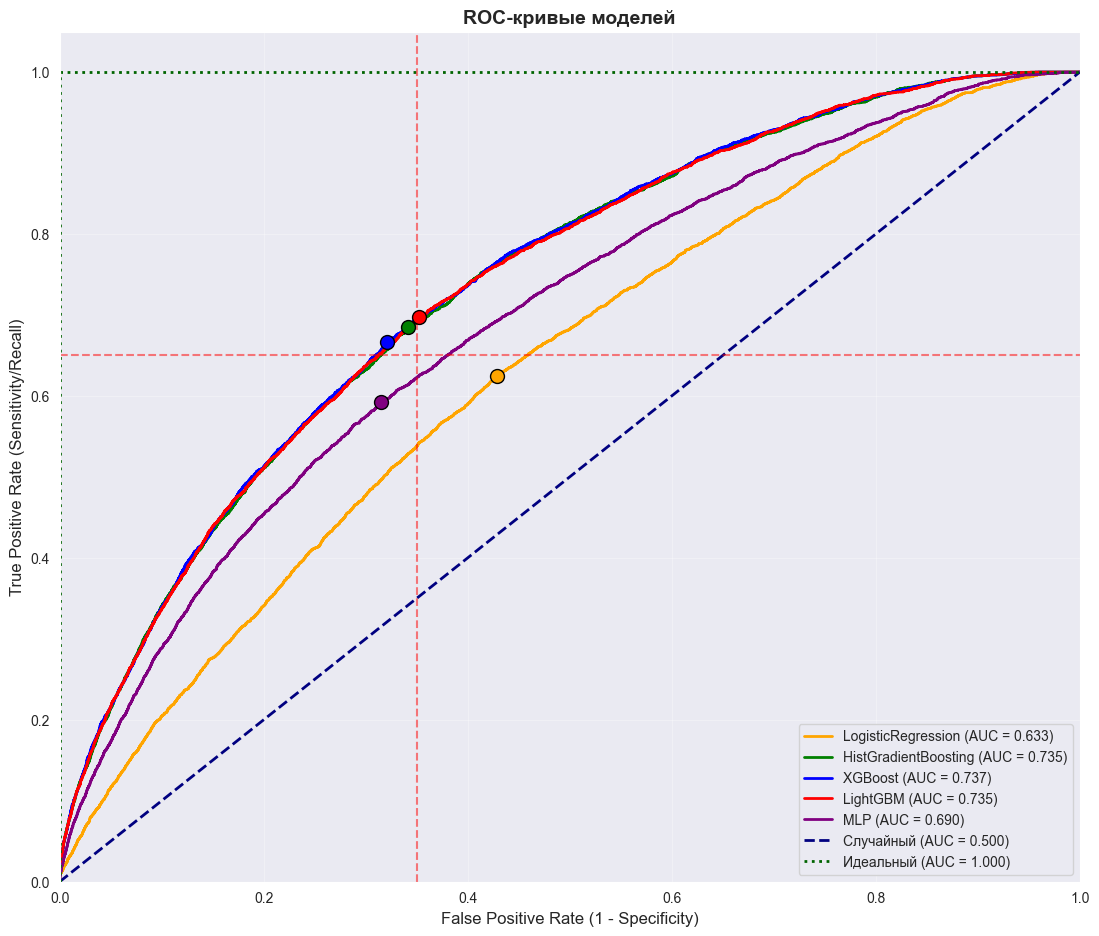

In [143]:
plt.figure(figsize=(12, 10))

roc_results = {}

# Цвета для разных моделей
colors = {
    'XGBoost': 'blue',
    'HistGradientBoosting': 'green',
    'LightGBM': 'red',
    'MLP': 'purple',
    'LogisticRegression': 'orange'
}

# Для каждой модели вычисляем и строим ROC-кривую
for name, model in models.items():
    if name in ['XGBoost', 'HistGradientBoosting', 'LightGBM', 'MLP', 'LogisticRegression']:
        try:
            # Получаем вероятности для положительного класса
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
            else:
                # Для некоторых моделей может потребоваться decision_function
                y_pred_proba = model.decision_function(X_test_processed)

            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            roc_results[name] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc,
                'thresholds': thresholds
            }

            plt.plot(fpr, tpr, color=colors.get(name, 'gray'),
                    lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

            # Находим оптимальную точку (ближайшую к верхнему левому углу)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]

            plt.scatter(fpr[optimal_idx], tpr[optimal_idx],
                       color=colors.get(name, 'gray'), s=100,
                       marker='o', edgecolors='black', zorder=5)

            # Выводим информацию об оптимальном пороге
            print(f"{name}:")
            print(f"  AUC = {roc_auc:.4f}")
            print(f"  Оптимальный порог = {optimal_threshold:.4f}")
            print(f"  При этом пороге: FPR = {fpr[optimal_idx]:.4f}, TPR = {tpr[optimal_idx]:.4f}")
            print(f"  Расстояние до идеальной точки (0,1): {np.sqrt(fpr[optimal_idx]**2 + (1-tpr[optimal_idx])**2):.4f}")
            print()

        except Exception as e:
            print(f"Ошибка при построении ROC-кривой для {name}: {e}")
            continue

# Случайный классификатор (бейзлайн)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный (AUC = 0.500)')

# Идеальный классификатор
plt.plot([0, 0, 1], [0, 1, 1], color='darkgreen', lw=2, linestyle=':', label='Идеальный (AUC = 1.000)')

# Настройка графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('ROC-кривые моделей', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Линия для целевого значения AUC = 0.65
plt.axhline(y=0.65, color='red', linestyle='--', alpha=0.5, label='Целевое AUC = 0.65')
plt.axvline(x=0.35, color='red', linestyle='--', alpha=0.5)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)

plt.show()

## Results

### Выбор финальной модели

In [144]:
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model_info = results[best_model_name]

In [145]:
print(f'ЛУЧШАЯ МОДЕЛЬ: {best_model_name}')
print(f'   ROC-AUC: {best_model_info['auc']:.4f}')

ЛУЧШАЯ МОДЕЛЬ: XGBoost
   ROC-AUC: 0.7370


### Сохранение лучшей модели

In [146]:
# Определяем топ-категории на всем датасете
top_categories_dict = {}
for col in categorical_cols:
    top_categories = X[col].value_counts().head(15).index
    top_categories_dict[col] = list(top_categories)

# Применяем обработку ко всему датасету
X_processed = X.copy()
for col in categorical_cols:
    if col in top_categories_dict:
        X_processed.loc[~X_processed[col].isin(top_categories_dict[col]), col] = 'other'

In [147]:
models[best_model_name]

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different trans

In [148]:
# Берем лучшую модель из словаря models и обучаем на всем датасете
start_time = time.time()
final_model = models[best_model_name]

# Обучаем на всем датасете
final_model.fit(X_processed, y)

training_time = time.time() - start_time
print(f'Обучение завершено за {training_time:.2f} секунд')

Обучение завершено за 56.69 секунд


In [149]:
# Проверяем качество модели (для контроля)
# Создаем небольшую валидационную выборку для проверки
X_val, X_check, y_val, y_check = train_test_split(
    X_processed, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

# Обучаем на 90% данных, проверяем на 10%
check_model = models[best_model_name]
check_model.fit(X_val, y_val)

y_check_pred_proba = check_model.predict_proba(X_check)[:, 1]
check_auc = roc_auc_score(y_check, y_check_pred_proba)
check_accuracy = accuracy_score(y_check, check_model.predict(X_check))
check_f1 = f1_score(y_check, check_model.predict(X_check))

print(f'Проверка на валидационной выборке (10% данных):')
print(f'  ROC-AUC: {check_auc:.4f}')
print(f'  Accuracy: {check_accuracy:.4f}')
print(f'  F1-Score: {check_f1:.4f}')
print(f'  Целевое значение (0.65) достигнуто: {check_auc >= 0.65}')

Проверка на валидационной выборке (10% данных):
  ROC-AUC: 0.7398
  Accuracy: 0.7158
  F1-Score: 0.0430
  Целевое значение (0.65) достигнуто: True


In [150]:
# Подготавливаем данные для сохранения
model_package = {
    'model': final_model,
    'model_name': best_model_name,
    'model_type': type(final_model.named_steps['classifier']).__name__,
    'preprocessor': preprocessor,
    'feature_names': X.columns.tolist(),
    'training_data_info': {
        'total_samples': len(X),
        'positive_samples': int(y.sum()),
        'negative_samples': int(len(y) - y.sum()),
        'conversion_rate': float(y.mean()),
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'training_time_seconds': float(training_time)
    },
    'performance_metrics': {
        'test_roc_auc': float(best_model_info['auc']),
        'test_accuracy': float(best_model_info['accuracy']),
        'test_f1_score': float(best_model_info['f1']),
        'validation_roc_auc': float(check_auc)
    },
    'model_parameters': final_model.named_steps['classifier'].get_params(),
    'pipeline_steps': list(final_model.named_steps.keys())
}

In [151]:
# Создаем папку для сохранения моделей если её нет
os.makedirs('../models', exist_ok=True)

# Сохраняем модель в pickle файл
model_filename = f'../models/conversion_model_{best_model_name}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

In [155]:
# Проверка загрузки и работы сохраненной модели
print('\n' + '=' * 80)
print('ПРОВЕРКА ЗАГРУЗКИ И РАБОТЫ СОХРАНЕННОЙ МОДЕЛИ')
print('=' * 80)

try:
    # Загружаем модель
    with open(model_filename, 'rb') as f:
        loaded_package = pickle.load(f)

    loaded_model = loaded_package['model']

    print('Модель успешно загружена!')

    # Создаем тестовые данные для проверки
    print(f'\nСоздаем тестовые данные')
    test_sample = X_processed.head(5).copy()

    # Делаем предсказания
    print(f'Делаем предсказания для 5 тестовых строк')
    predictions = loaded_model.predict(test_sample)
    probabilities = loaded_model.predict_proba(test_sample)[:, 1]

    print('\nРезультаты предсказаний:')
    print('-' * 60)
    for i in range(len(test_sample)):
        actual_label = y.iloc[i]
        predicted_label = predictions[i]
        probability = probabilities[i]

        print(f'Строка {i + 1}:')
        print(f'  Фактический класс: {actual_label} ({'конверсия' if actual_label == 1 else 'нет конверсии'})')
        print(f'  Предсказанный класс: {predicted_label}')
        print(f'  Вероятность конверсии: {probability:.4f}')
        print(f'  Совпадение: {"yes" if actual_label == predicted_label else "no"}')
        print()

    # Выводим ключевую информацию
    print('\nКлючевая информация о модели:')
    print('-' * 40)
    print(f'Название: {loaded_package['model_name']}')
    print(f'Тип: {loaded_package['model_type']}')
    print(f'Дата обучения: {loaded_package['training_data_info']['training_date']}')
    print(f'Размер обучающих данных: {loaded_package['training_data_info']['total_samples']:,}')
    print(f'ROC-AUC на тесте: {loaded_package['performance_metrics']['test_roc_auc']:.4f}')

except Exception as e:
    print(f'Ошибка при загрузке или тестировании модели: {e}')
    import traceback

    traceback.print_exc()


ПРОВЕРКА ЗАГРУЗКИ И РАБОТЫ СОХРАНЕННОЙ МОДЕЛИ
Модель успешно загружена!

Создаем тестовые данные
Делаем предсказания для 5 тестовых строк

Результаты предсказаний:
------------------------------------------------------------
Строка 1:
  Фактический класс: 0 (нет конверсии)
  Предсказанный класс: 0
  Вероятность конверсии: 0.3458
  Совпадение: yes

Строка 2:
  Фактический класс: 0 (нет конверсии)
  Предсказанный класс: 0
  Вероятность конверсии: 0.4844
  Совпадение: yes

Строка 3:
  Фактический класс: 0 (нет конверсии)
  Предсказанный класс: 0
  Вероятность конверсии: 0.3989
  Совпадение: yes

Строка 4:
  Фактический класс: 0 (нет конверсии)
  Предсказанный класс: 0
  Вероятность конверсии: 0.0981
  Совпадение: yes

Строка 5:
  Фактический класс: 0 (нет конверсии)
  Предсказанный класс: 0
  Вероятность конверсии: 0.4944
  Совпадение: yes


Ключевая информация о модели:
----------------------------------------
Название: XGBoost
Тип: XGBClassifier
Дата обучения: 2025-12-26 18:52:40
Разме

### Итог

Лучшими моделями для предсказания конверсии оказались XGBoost и LightGBM. Их значения ROC-AUC превышают целевую метрику 0.65 почта на 10%. Итоговая модель успешно обучена на полном датасете и сохранена в файл conversion_prediction_model.pkl со всем необходимым для использования в production. Модель включает полный пайплайн препроцессинга и готова к использованию для предсказания целевых действий пользователей на основе их атрибутов.